In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom, PixArtAlphaPipeline_custom_CLIP
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:211: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Please use that instead; we will remove `torch.library.impl_abstract` in a future version of PyTorch.
  @torch.library.impl_abstract("xformers_flash::flash_fwd")
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/xformers/ops/fmha/flash.py:344: FutureWarning: `torch.library.impl_abstract` was renamed to `torch.library.register_fake`. Pleas

In [4]:
from transformers import CLIPTextModelWithProjection, CLIPTokenizer
# Load SDXL's text encoder and tokenizer (text_encoder_2 and tokenizer_2)
text_encoder = CLIPTextModelWithProjection.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="text_encoder_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)
tokenizer = CLIPTokenizer.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", subfolder="tokenizer_2", 
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",)

In [5]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_CLIPemb_DiT_mini_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length, "caption_channels": config.caption_channels}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=config.caption_channels,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )

2026-01-25 01:13:01,323 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.


In [6]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

/tmp/ipykernel_2213885/1495998778.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))


<All keys matched successfully>

In [7]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5


In [8]:
from itertools import product
def generate_test_prompts_collection_and_parsed_words():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words

In [9]:
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
prompt_df["relation"] = prompt_df.relation.apply(lambda x: tuple(x))
prompt_df["relation_str"] = prompt_df.relation.apply(lambda x: "_".join(x))

In [10]:
prompts

['red square is above the blue triangle',
 'red square is below the blue triangle',
 'red square is to the left of the blue triangle',
 'red square is to the right of the blue triangle',
 'red square is above and to the left of the blue triangle',
 'red square is above and to the right of the blue triangle',
 'red square is below and to the left of the blue triangle',
 'red square is below and to the right of the blue triangle',
 'red square is above the blue circle',
 'red square is below the blue circle',
 'red square is to the left of the blue circle',
 'red square is to the right of the blue circle',
 'red square is above and to the left of the blue circle',
 'red square is above and to the right of the blue circle',
 'red square is below and to the left of the blue circle',
 'red square is below and to the right of the blue circle',
 'red triangle is above the blue square',
 'red triangle is below the blue square',
 'red triangle is to the left of the blue square',
 'red triangle 

### Pipeline for CLIP

In [48]:
from typing import Union, List, Optional
import logging
class PixArtAlphaPipeline_custom_CLIP(PixArtAlphaPipeline_custom):
    """Slightly modify the encode_prompt function to use the text encoder of CLIP"""
    def encode_prompt(
        self,
        prompt: Union[str, List[str]],
        do_classifier_free_guidance: bool = True,
        negative_prompt: str = "",
        num_images_per_prompt: int = 1,
        device: Optional[torch.device] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        clean_caption: bool = False,
        max_sequence_length: int = 120,
        **kwargs,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt not to guide the image generation. If not defined, one has to pass `negative_prompt_embeds`
                instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is less than `1`). For
                PixArt-Alpha, this should be "".
            do_classifier_free_guidance (`bool`, *optional*, defaults to `True`):
                whether to use classifier free guidance or not
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                number of images that should be generated per prompt
            device: (`torch.device`, *optional*):
                torch device to place the resulting embeddings on
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha, it's should be the embeddings of the ""
                string.
            clean_caption (`bool`, defaults to `False`):
                If `True`, the function will preprocess and clean the provided caption before encoding.
            max_sequence_length (`int`, defaults to 120): Maximum sequence length to use for the prompt.
        """

        # if "mask_feature" in kwargs:
        #     deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
        #     deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)

        if device is None:
            device = self._execution_device

        # See Section 3.1. of the paper.
        max_length = max_sequence_length

        if prompt_embeds is None:
            prompt = self._text_preprocessing(prompt, clean_caption=clean_caption)
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = self.tokenizer.batch_decode(untruncated_ids[:, max_length - 1 : -1])

            prompt_attention_mask = text_inputs.attention_mask
            prompt_attention_mask = prompt_attention_mask.to(device)

            prompt_embeds_outputs = self.text_encoder(text_input_ids.to(device), attention_mask=prompt_attention_mask)
            prompt_embeds = prompt_embeds_outputs.last_hidden_state

        if self.text_encoder is not None:
            dtype = self.text_encoder.dtype
        elif self.transformer is not None:
            dtype = self.transformer.dtype
        else:
            dtype = None

        prompt_embeds = prompt_embeds.to(dtype=dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings and attention mask for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)
        prompt_attention_mask = prompt_attention_mask.repeat(1, num_images_per_prompt)
        prompt_attention_mask = prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens = [negative_prompt] * bs_embed if isinstance(negative_prompt, str) else negative_prompt
            uncond_tokens = self._text_preprocessing(uncond_tokens, clean_caption=clean_caption)
            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_attention_mask=True,
                add_special_tokens=True,
                return_tensors="pt",
            )
            negative_prompt_attention_mask = uncond_input.attention_mask
            negative_prompt_attention_mask = negative_prompt_attention_mask.to(device)

            negative_prompt_embeds_outputs = self.text_encoder(
                uncond_input.input_ids.to(device), attention_mask=negative_prompt_attention_mask
            )
            negative_prompt_embeds = negative_prompt_embeds_outputs.last_hidden_state

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

            negative_prompt_attention_mask = negative_prompt_attention_mask.repeat(1, num_images_per_prompt)
            negative_prompt_attention_mask = negative_prompt_attention_mask.view(bs_embed * num_images_per_prompt, -1)
        else:
            negative_prompt_embeds = None
            negative_prompt_attention_mask = None

        return prompt_embeds, prompt_attention_mask, negative_prompt_embeds, negative_prompt_attention_mask

In [46]:
pipeline = PixArtAlphaPipeline_custom_CLIP.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

pipeline.tokenizer = tokenizer
pipeline.to(device="cuda", dtype=weight_dtype);
# pipeline.to(device="cuda", dtype=torch.bfloat16);
pipeline.text_encoder = text_encoder.to(device="cuda", )
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Expected types for transformer: (<class 'diffusers.models.transformers.pixart_transformer_2d.PixArtTransformer2DModel'>,), got <class 'diffusers.models.transformers.transformer_2d.Transformer2DModel'>.
/tmp/ipykernel_2213885/260167962.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full

<All keys matched successfully>

  0%|          | 0/14 [00:00<?, ?it/s]

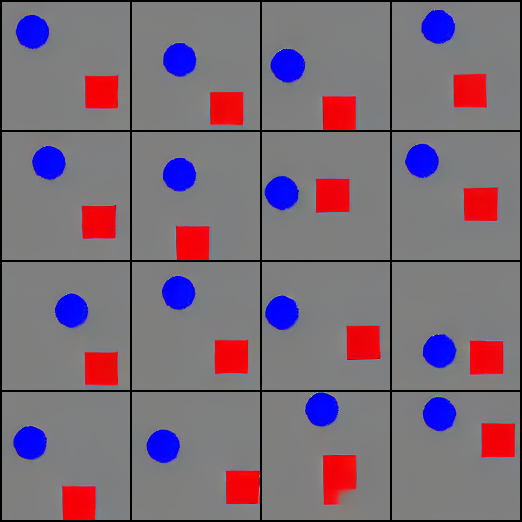

In [49]:
max_sequence_length = config.model_max_length

attnvis_store.clear_activation()
prompt = "red square is below and to the right of the blue circle"
with torch.no_grad():
    uncond_inputs = tokenizer(
        "", 
        max_length=max_sequence_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    uncond_outputs = text_encoder(uncond_inputs.input_ids, attention_mask=uncond_inputs.attention_mask)
    uncond_embeds = uncond_outputs.last_hidden_state
    uncond_mask = uncond_inputs.attention_mask
    inputs = tokenizer(
        prompt, 
        max_length=max_sequence_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ).to("cuda")
    caption_outputs = text_encoder(inputs.input_ids, attention_mask=inputs.attention_mask)
    caption_embeds = caption_outputs.last_hidden_state
    caption_attn_mask = inputs.attention_mask
output = pipeline(prompt=None,
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        prompt_embeds=caption_embeds,
        prompt_attention_mask=caption_attn_mask,
        negative_prompt=None,
        negative_prompt_embeds=uncond_embeds,
        negative_prompt_attention_mask=uncond_mask,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

### Below and right

  0%|          | 0/14 [00:00<?, ?it/s]

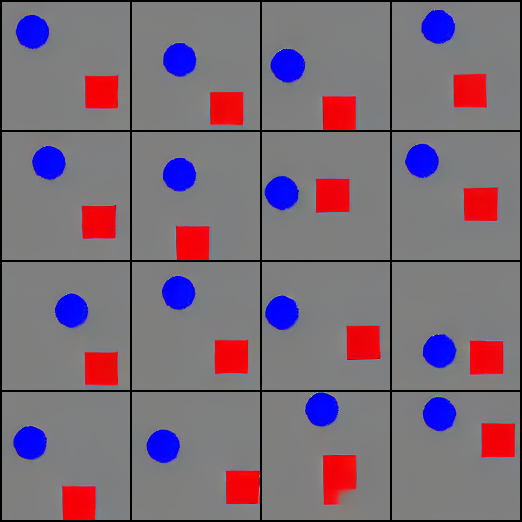

In [50]:
output = pipeline(prompt=prompt,
        num_inference_steps=14,
        max_sequence_length=20, 
        generator=torch.Generator(device="cuda").manual_seed(42),
        guidance_scale=4.5,
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
noise_pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

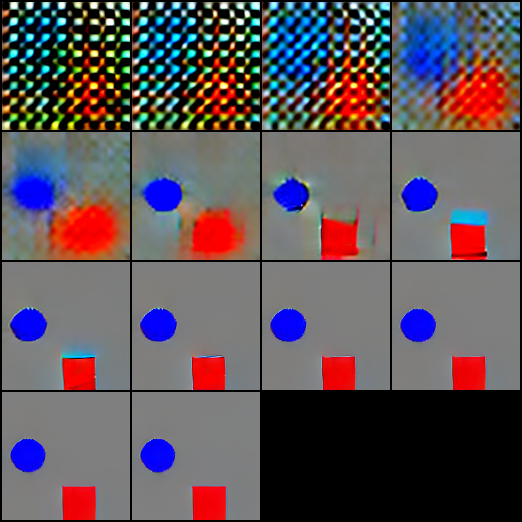

In [102]:
alpha_t, sigma_t = pipeline.scheduler._sigma_to_alpha_sigma_t(pipeline.scheduler.sigmas)
sample_i = 2
noise_pred_traj[:, sample_i] # 14, 4, 16, 16
latents_traj[:, sample_i] # 15, 4, 16, 16
x0_pred_traj = (latents_traj[:-1, sample_i] - sigma_t[:-1, None, None, None] * noise_pred_traj[:, sample_i]) / alpha_t[:-1, None, None, None]
with torch.no_grad():
    x0_pred_traj_img_tsrs = pipeline.vae.decode(x0_pred_traj.half().cuda() / pipeline.vae.config.scaling_factor, return_dict=False)[0]

x0_pred_traj_imgs = pipeline.image_processor.postprocess(x0_pred_traj_img_tsrs, output_type="pil")
display(pil_images_to_grid(x0_pred_traj_imgs))

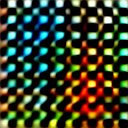

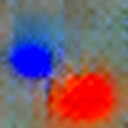

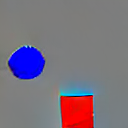

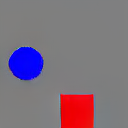

In [103]:
display(pil_images_to_grid([x0_pred_traj_imgs[0]]))
display(pil_images_to_grid([x0_pred_traj_imgs[4]]))
display(pil_images_to_grid([x0_pred_traj_imgs[8]]))
display(pil_images_to_grid([x0_pred_traj_imgs[12]]))

In [26]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(len(model.blocks))]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(len(model.blocks))]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([6, 14, 32, 6, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([6, 14, 32, 6, 64, 20])


In [29]:
def create_multi_hot_token_mask_CLIP(tokens, target_words, seq_len=None):
    mask = th.zeros(len(tokens) if seq_len is None else seq_len, dtype=th.bool)
    for i, token in enumerate(tokens):
        # Remove the special prefix if present
        clean_token = token.replace('▁', '') if token.startswith('▁') else token
        if clean_token.endswith('</w>'):
            clean_token = clean_token.split('</w>')[0]
        if clean_token.startswith('<|') and clean_token.endswith('|>'):
            continue
        if clean_token in target_words:
            mask[i] = True
    return mask


def CLIP_tokenizer_split(tokenizer, prompt, max_length=20):
    # Create multi-hot masks for different types of words
    text_tokens_and_mask = tokenizer(
        prompt,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    input_ids = text_tokens_and_mask['input_ids']
    if input_ids.ndim == 2:
        input_ids = input_ids[0]
    token_splits = [tokenizer.decode(i) for i in input_ids]
    return token_splits

token_splits = CLIP_tokenizer_split(pipeline.tokenizer, prompt)

In [28]:
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/home12/binxuwang/Github/DiffusionObjectRelation/Figures/DiT_CLIP_L0H5_L0H2_dissection"
os.makedirs(figdir, exist_ok=True)

In [33]:
cross_attn_map_stacked.shape

torch.Size([6, 14, 32, 6, 64, 20])

In [34]:
i_layer = 0
j_head = 5
k_step = 5
n_images = 16
token_splits = CLIP_tokenizer_split(pipeline.tokenizer, prompt)
token_mask = create_multi_hot_token_mask_CLIP(token_splits, ["below"], seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape

torch.Size([16, 64])

In [35]:
prompt = "red square is below and to the right of the blue circle"

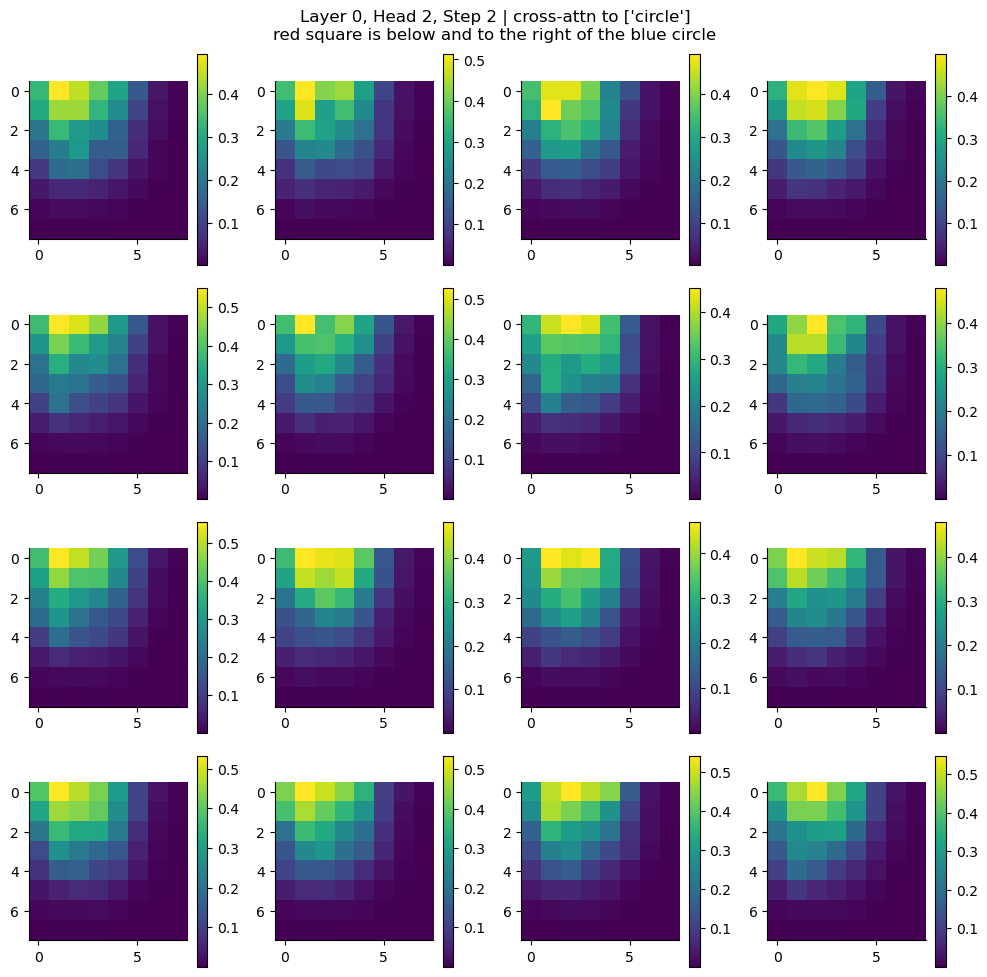

In [39]:
i_layer = 0
j_head = 2
k_step = 2
n_images = 16
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

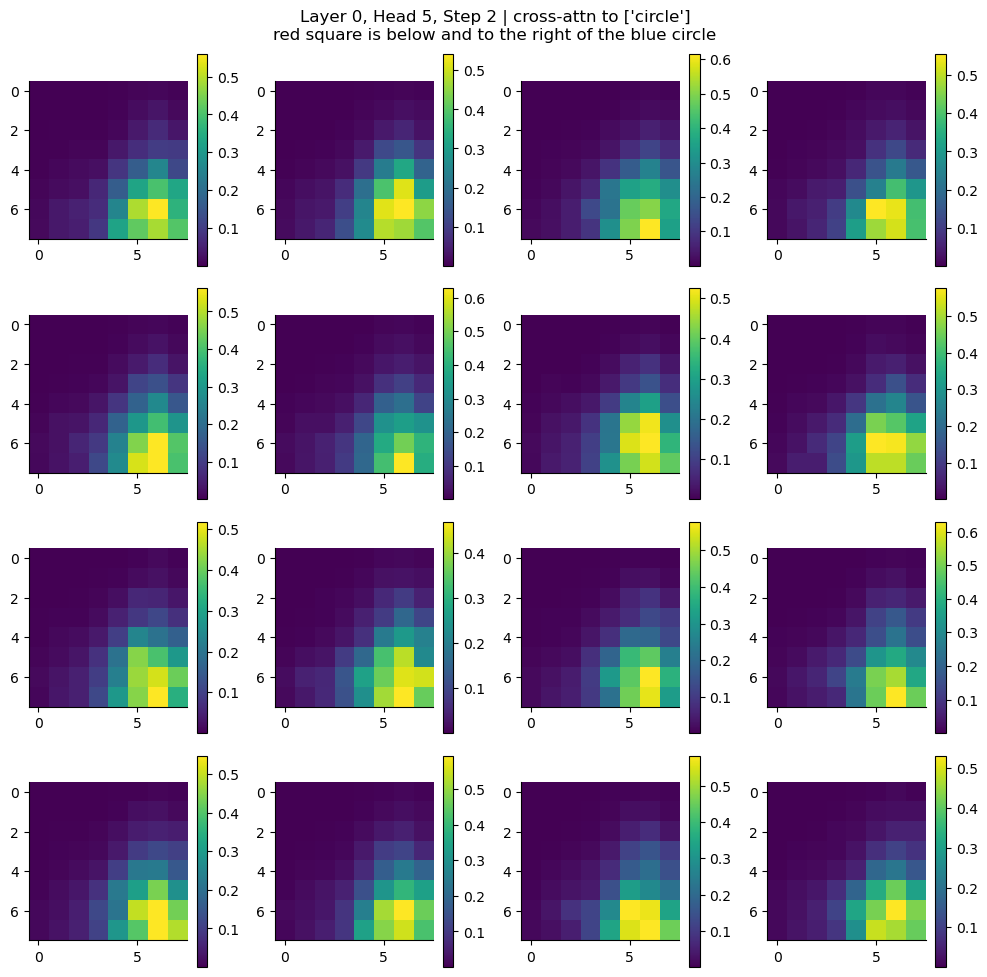

In [38]:
i_layer = 0
j_head = 5
k_step = 2
n_images = 16
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, k_step, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
axs = axs.flatten()
for i_sample in range(16):
    plt.sca(axs[i_sample])
    plt.imshow(L2H8_cross_attn_maps[i_sample, :].view(8, 8))
    plt.colorbar()
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Step {k_step} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

### Attention QK checking of L2H8

In [51]:
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

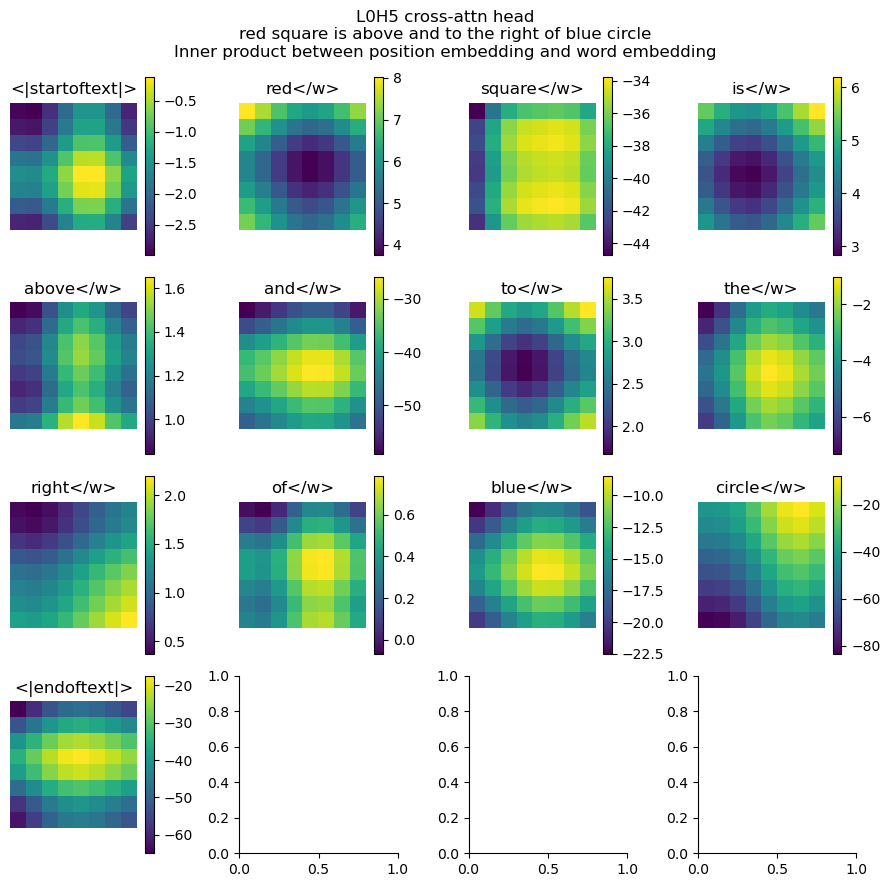

In [90]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 5
device = "cpu"
# relation_words = ["above", "below", "right", "left", ]
# token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
# word_embeds, attn_mask = pipeline.text_encoder(token_ids)
prompt_words = ["red","square", "is", "above", "and", "to", "the", "right", "of", "blue", "circle"]
token_ids = pipeline.tokenizer.encode(" ".join(prompt_words), max_length=20, truncation=False, add_special_tokens=True, return_tensors="pt")
token_words = pipeline.tokenizer.convert_ids_to_tokens(token_ids.squeeze(0))# [pipeline.tokenizer.decode_i(token_id) for token_id in token_ids[0]]
outputs = pipeline.text_encoder(token_ids.to("cuda"))
word_embeds = outputs.last_hidden_state
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

figh, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for i_word in range(len(token_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.axis("off")
    plt.colorbar()
    plt.title(token_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\n{' '.join(prompt_words)}\nInner product between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

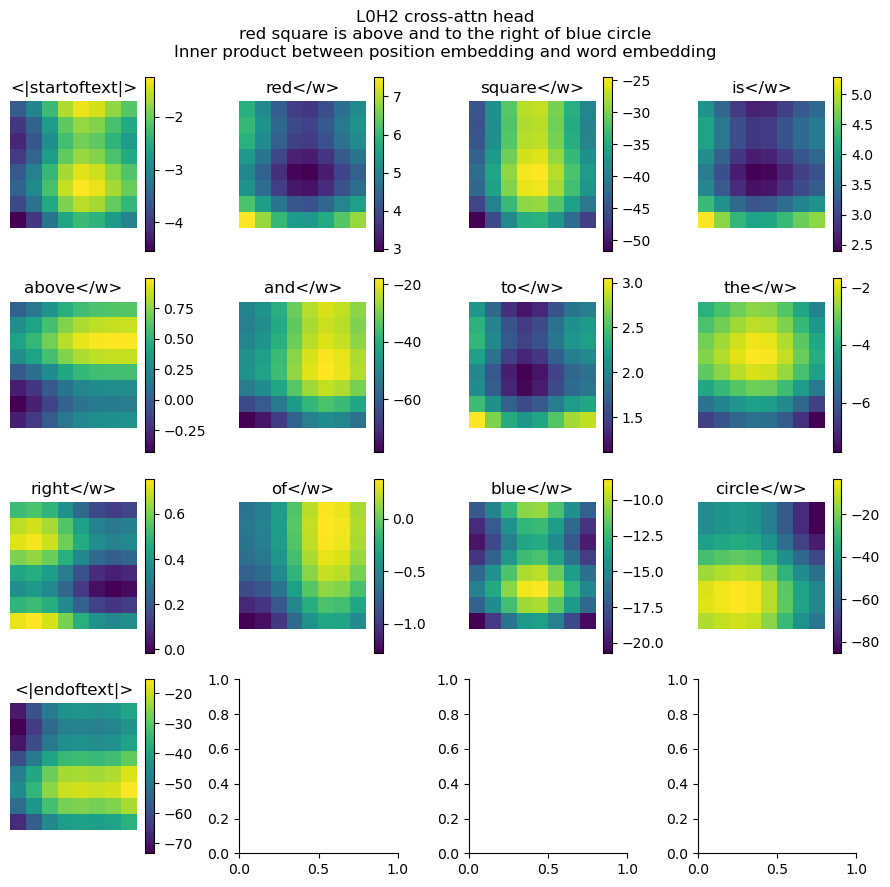

In [98]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 2
device = "cpu"
# relation_words = ["above", "below", "right", "left", ]
# token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
# word_embeds, attn_mask = pipeline.text_encoder(token_ids)
prompt_words = ["red","square", "is", "above", "and", "to", "the", "right", "of", "blue", "circle"]
token_ids = pipeline.tokenizer.encode(" ".join(prompt_words), max_length=20, truncation=False, add_special_tokens=True, return_tensors="pt")
token_words = pipeline.tokenizer.convert_ids_to_tokens(token_ids.squeeze(0))# [pipeline.tokenizer.decode_i(token_id) for token_id in token_ids[0]]
outputs = pipeline.text_encoder(token_ids.to("cuda"))
word_embeds = outputs.last_hidden_state
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

figh, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for i_word in range(len(token_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.axis("off")
    plt.colorbar()
    plt.title(token_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\n{' '.join(prompt_words)}\nInner product between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

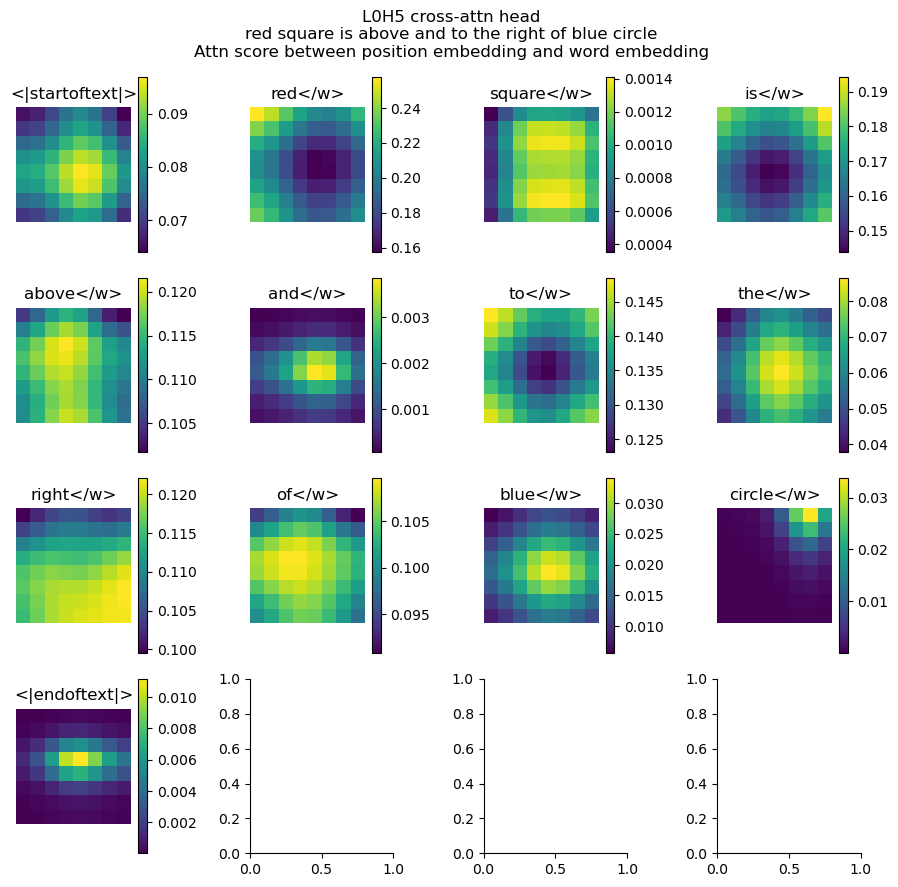

In [97]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 5
device = "cpu"
# relation_words = ["above", "below", "right", "left", ]
# token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
# word_embeds, attn_mask = pipeline.text_encoder(token_ids)
prompt_words = ["red","square", "is", "above", "and", "to", "the", "right", "of", "blue", "circle"]
token_ids = pipeline.tokenizer.encode(" ".join(prompt_words), max_length=20, truncation=False, add_special_tokens=True, return_tensors="pt")
token_words = pipeline.tokenizer.convert_ids_to_tokens(token_ids.squeeze(0))# [pipeline.tokenizer.decode_i(token_id) for token_id in token_ids[0]]
outputs = pipeline.text_encoder(token_ids.to("cuda"))
word_embeds = outputs.last_hidden_state
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

figh, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
inner_prod_mat = pos_embed_2q_h8 @ word_embed_2k_h8.T
attn_score_mat = inner_prod_mat / np.sqrt(head_dim)
attn_score_mat = torch.softmax(attn_score_mat, dim=-1)

for i_word in range(len(token_words)):
    plt.sca(axs[i_word])
    # inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    attn_score = attn_score_mat[:, i_word:i_word+1]
    plt.imshow(attn_score.view(8, 8).detach().cpu().numpy())
    plt.axis("off")
    plt.colorbar()
    plt.title(token_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\n{' '.join(prompt_words)}\nAttn score between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

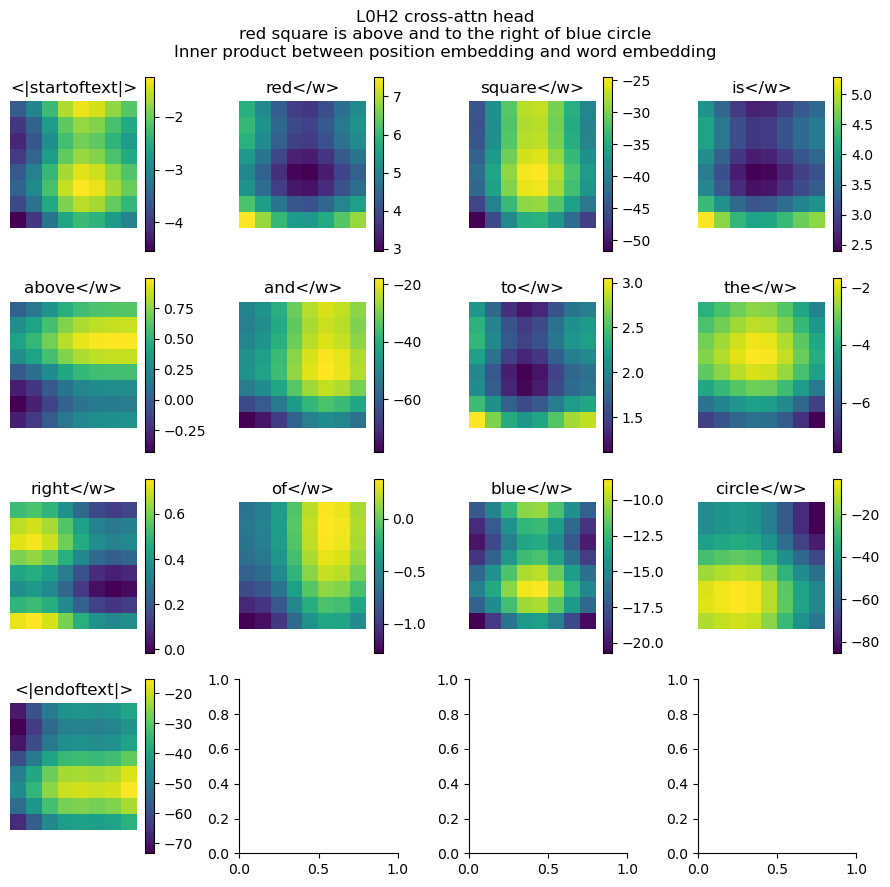

In [93]:
hidden_size = 384
head_num = 6
base_size = 16 // 2
head_dim = hidden_size // head_num
layer_idx = 0
head_idx = 2
device = "cpu"
# relation_words = ["above", "below", "right", "left", ]
# token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
# word_embeds, attn_mask = pipeline.text_encoder(token_ids)
prompt_words = ["red","square", "is", "above", "and", "to", "the", "right", "of", "blue", "circle"]
token_ids = pipeline.tokenizer.encode(" ".join(prompt_words), max_length=20, truncation=False, add_special_tokens=True, return_tensors="pt")
token_words = pipeline.tokenizer.convert_ids_to_tokens(token_ids.squeeze(0))# [pipeline.tokenizer.decode_i(token_id) for token_id in token_ids[0]]
outputs = pipeline.text_encoder(token_ids.to("cuda"))
word_embeds = outputs.last_hidden_state
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

figh, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for i_word in range(len(token_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.axis("off")
    plt.colorbar()
    plt.title(token_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\n{' '.join(prompt_words)}\nInner product between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

### Time course of cross attention

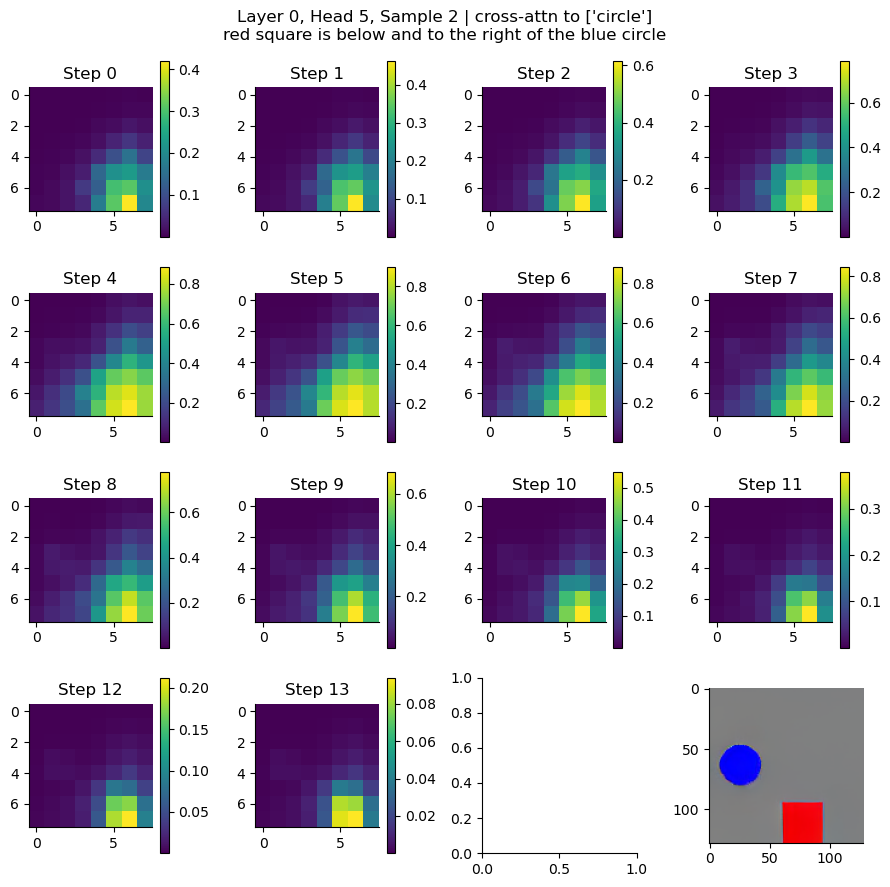

In [41]:
i_layer = 0
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

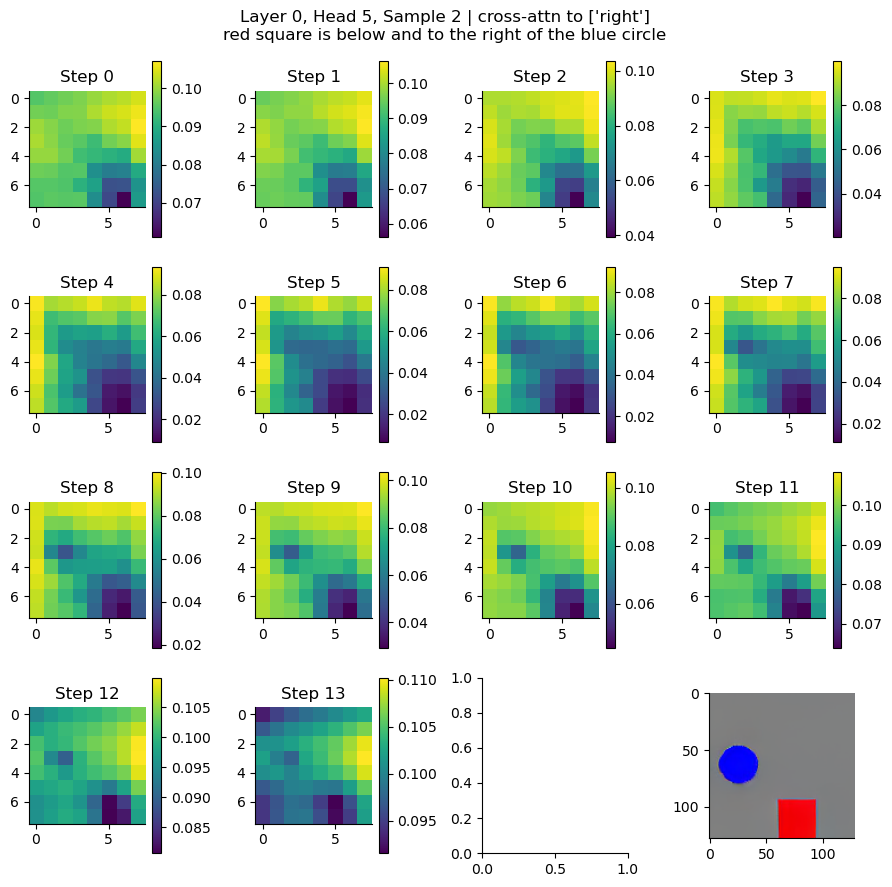

In [44]:
i_layer = 0
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["right"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

In [ ]:
figdir

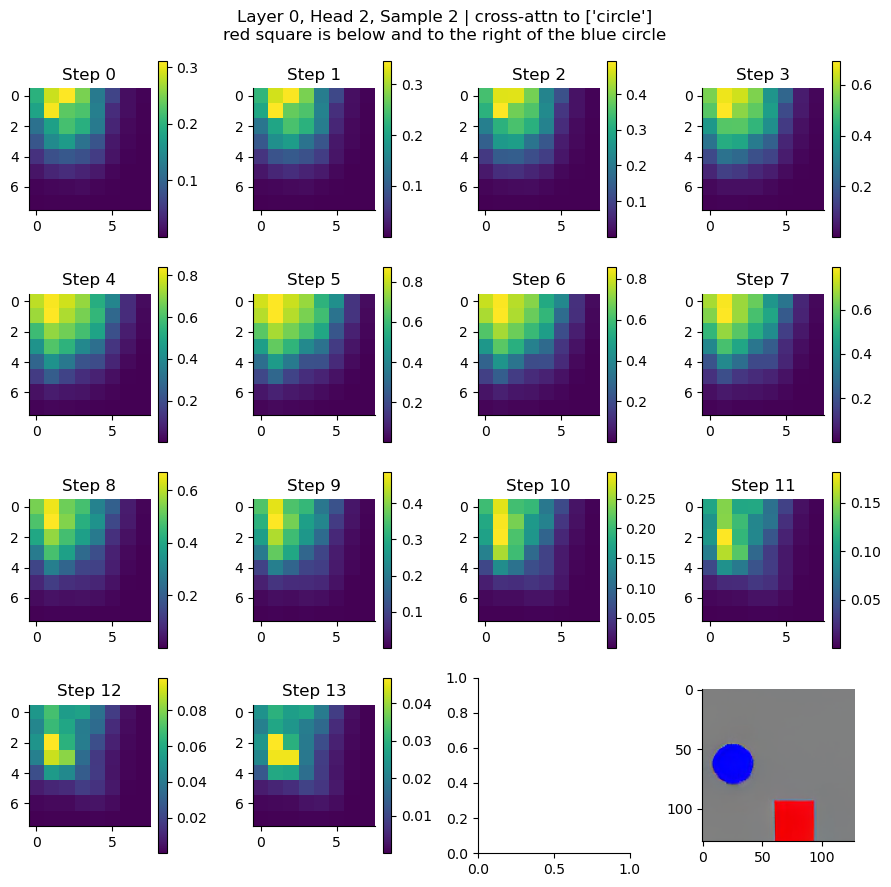

In [40]:
i_layer = 0
j_head = 2
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

[autoreload of pydantic.config failed: Traceback (most recent call last):
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/pydantic/config.py", line 14, in <module>
    from .warnings import PydanticDeprecatedSince211
ImportError: cannot import name 'PydanticDeprecatedSince211' fr

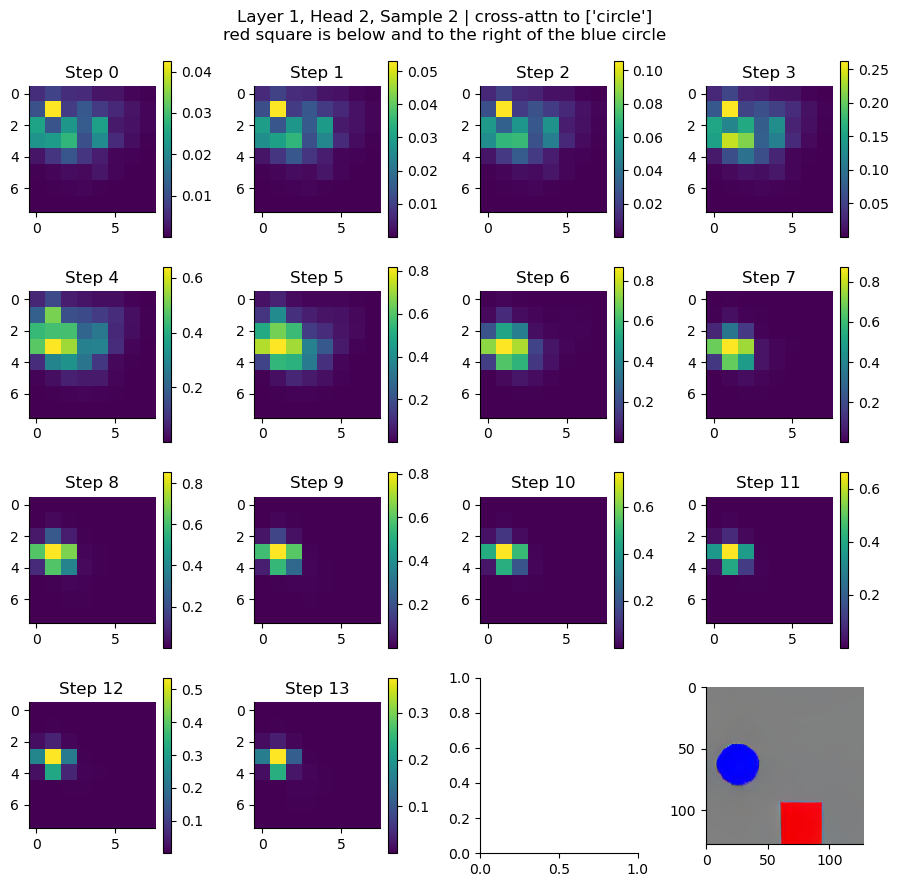

In [99]:
i_layer = 1
j_head = 2
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

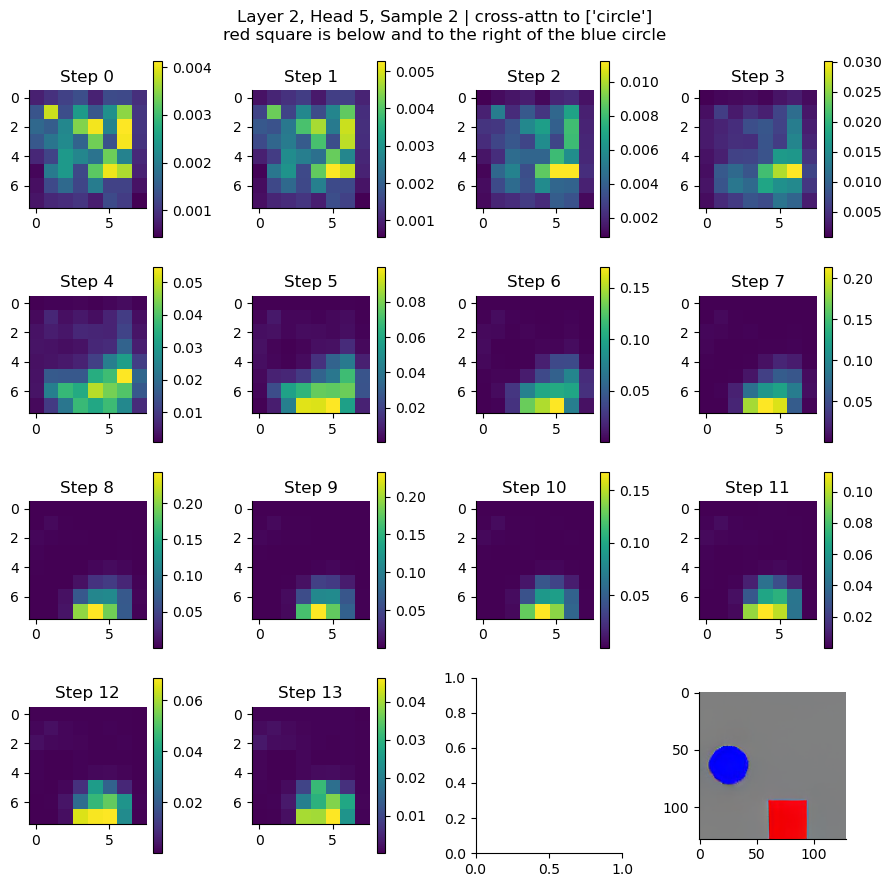

In [100]:
i_layer = 2
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["circle"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

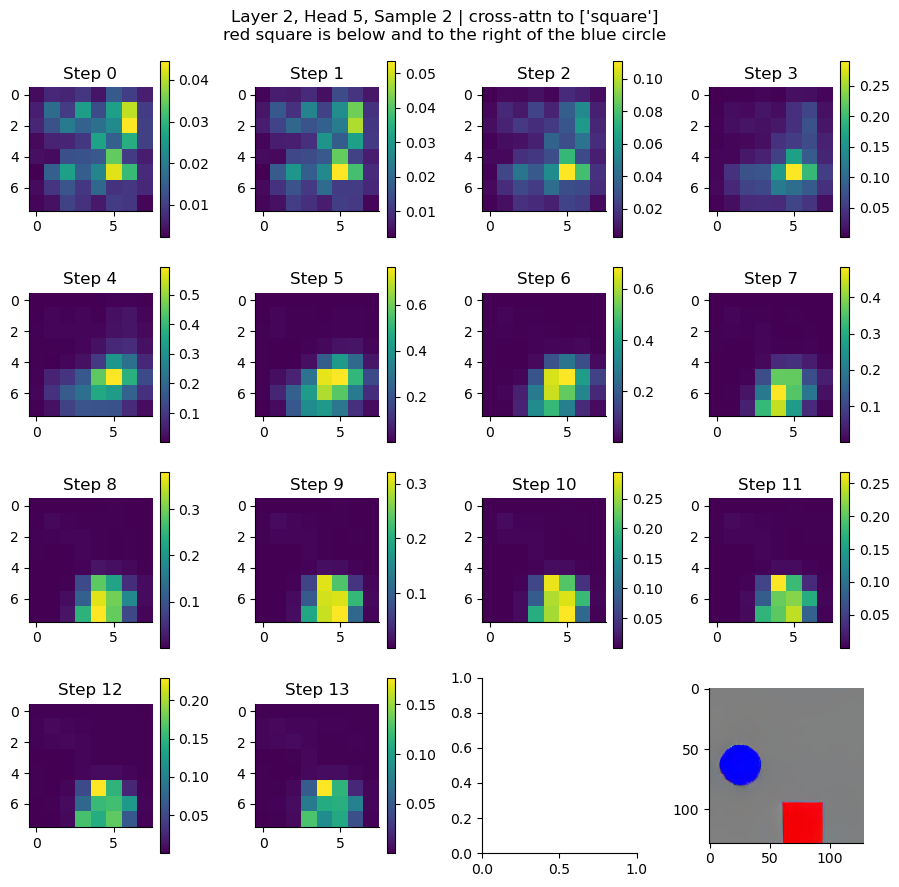

In [101]:
i_layer = 2
j_head = 5
# k_step = 0
n_images = 16
i_sample = 2
target_words = ["square"]
token_mask = create_multi_hot_token_mask_CLIP(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

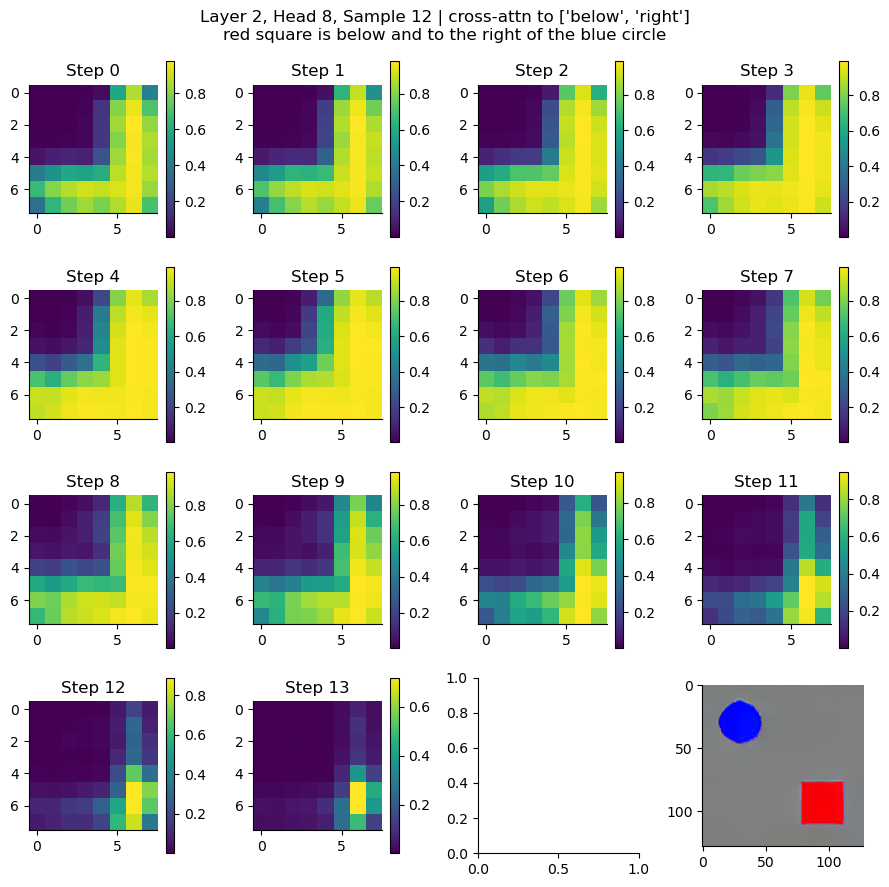

In [25]:
i_layer = 2
j_head = 8
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["below", "right"]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

### 

### Above and left

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

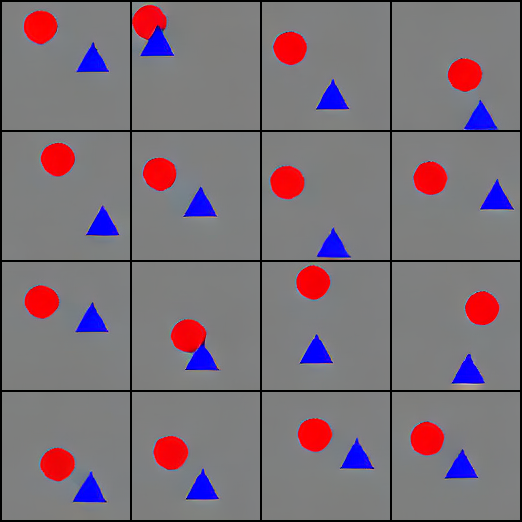

In [54]:
attnvis_store.clear_activation()
prompt = "red circle is above and to the left of the blue triangle"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [55]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


In [61]:
prompt

'red circle is above and to the left of the blue triangle'

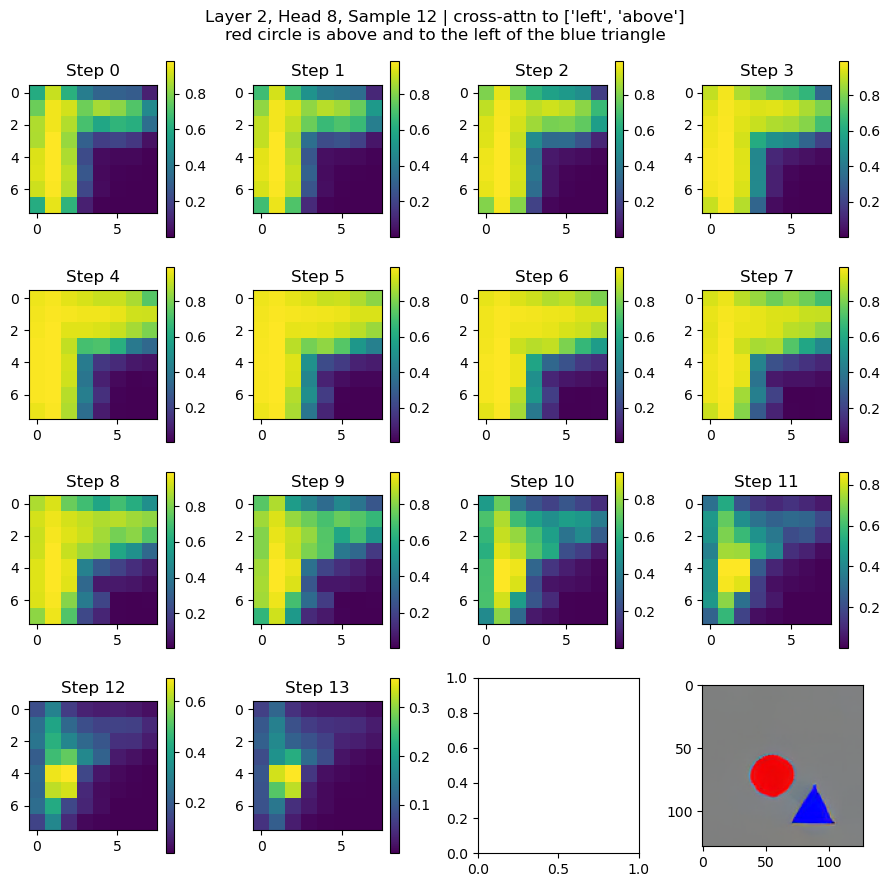

In [58]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", "above",]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

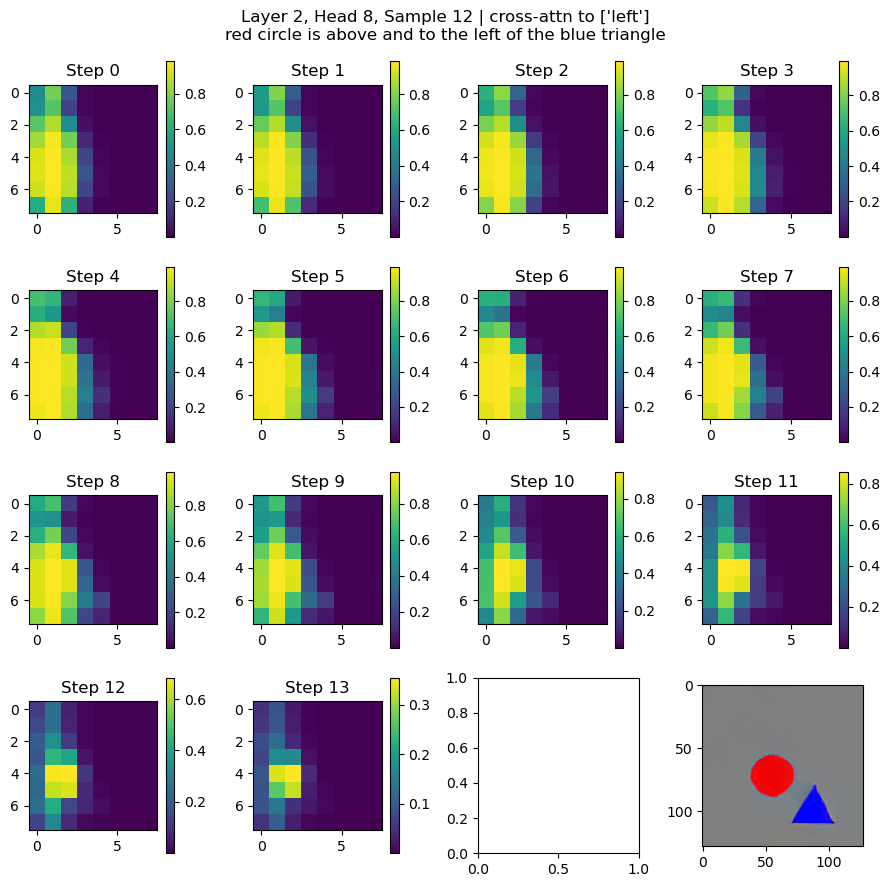

In [59]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

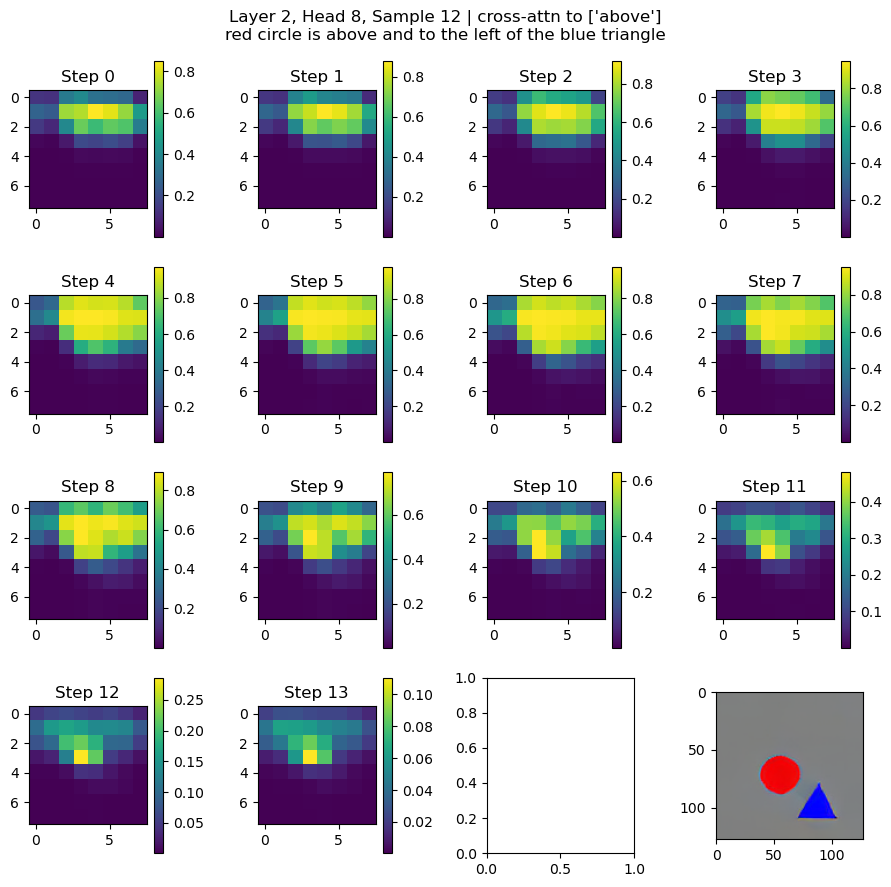

In [60]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["above", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

### Ambiguous

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

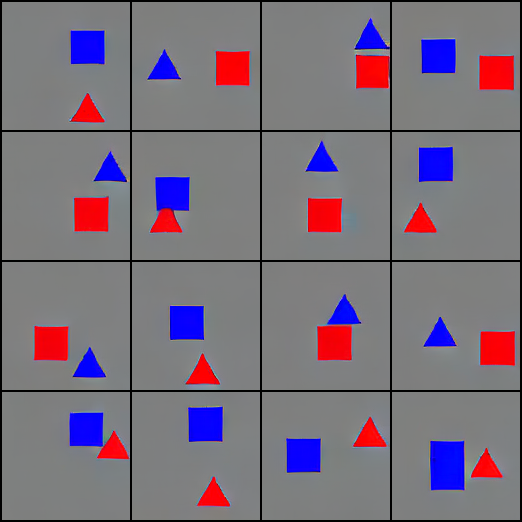

In [62]:
attnvis_store.clear_activation()
prompt = "red square is above and below and to the left of and right of the blue triangle"
output = pipeline(prompt, 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [63]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


In [68]:
prompt

'red square is above and below and to the left of and right of the blue triangle'

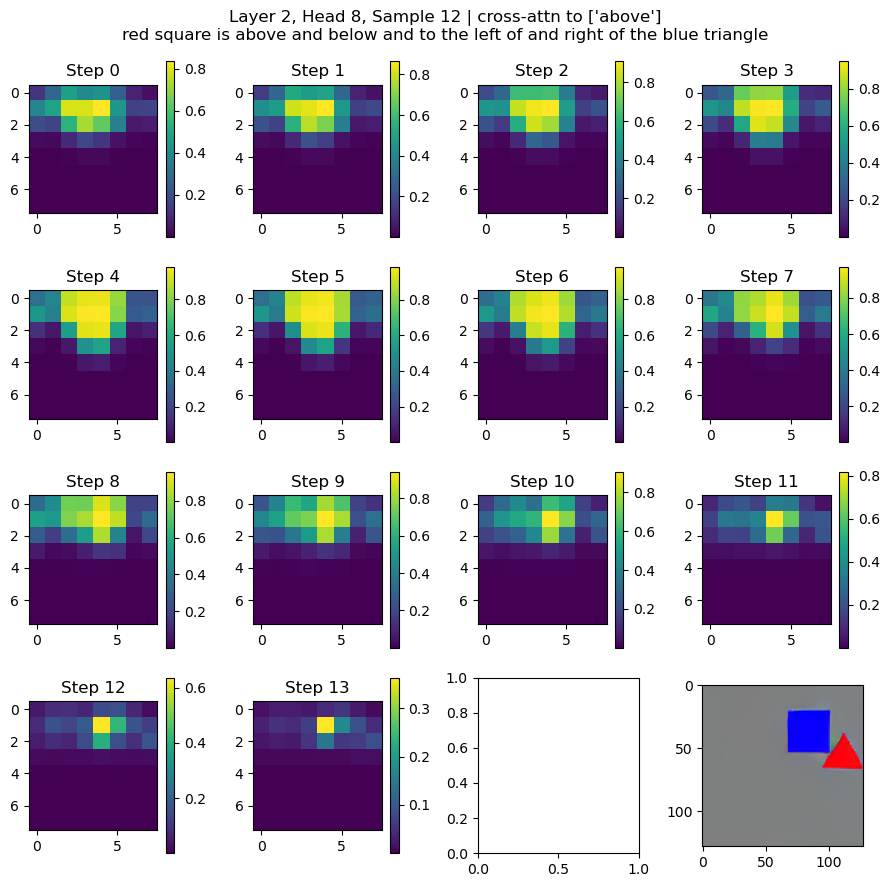

In [64]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["above", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

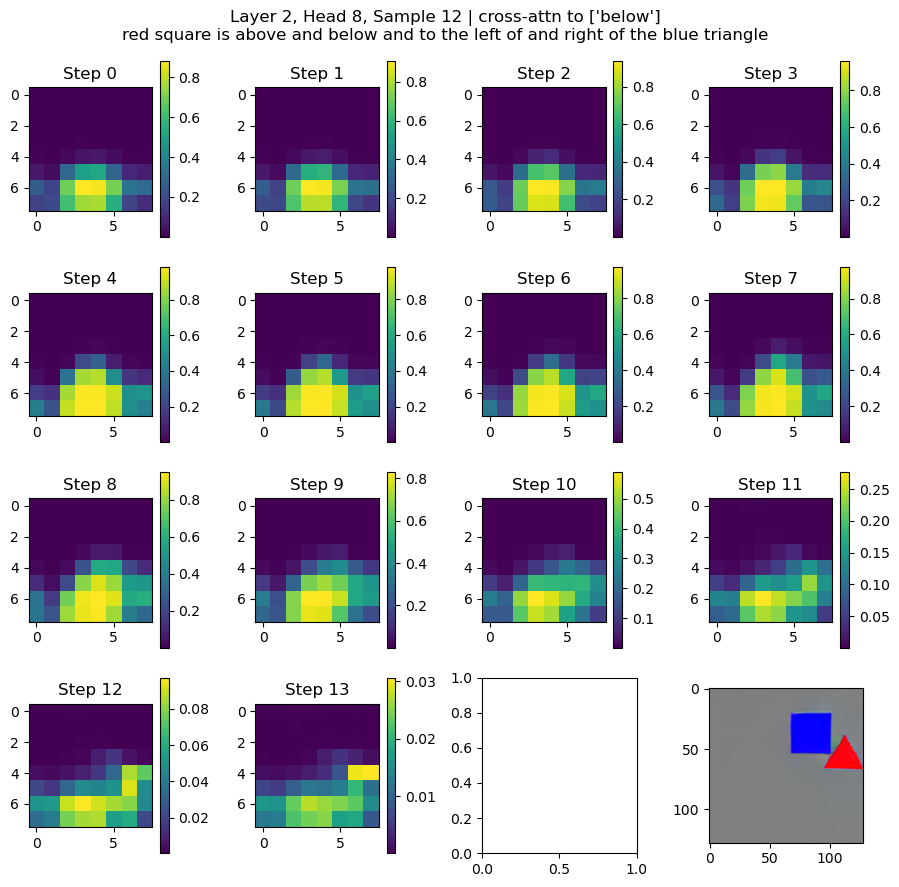

In [65]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["below", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

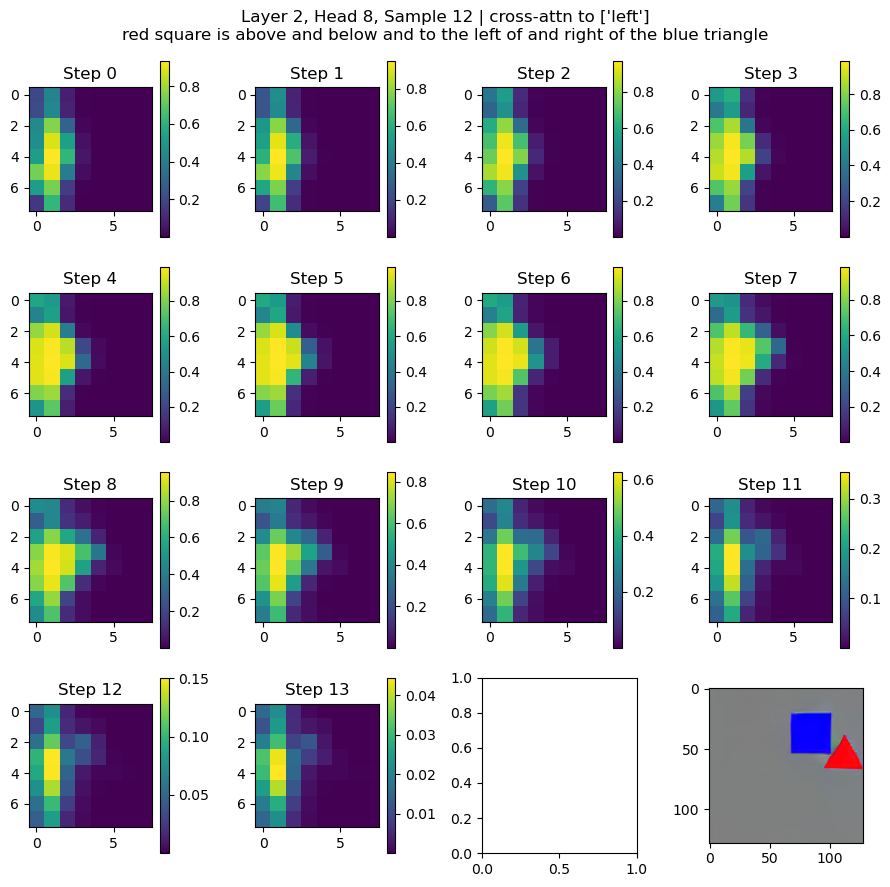

In [66]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["left", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

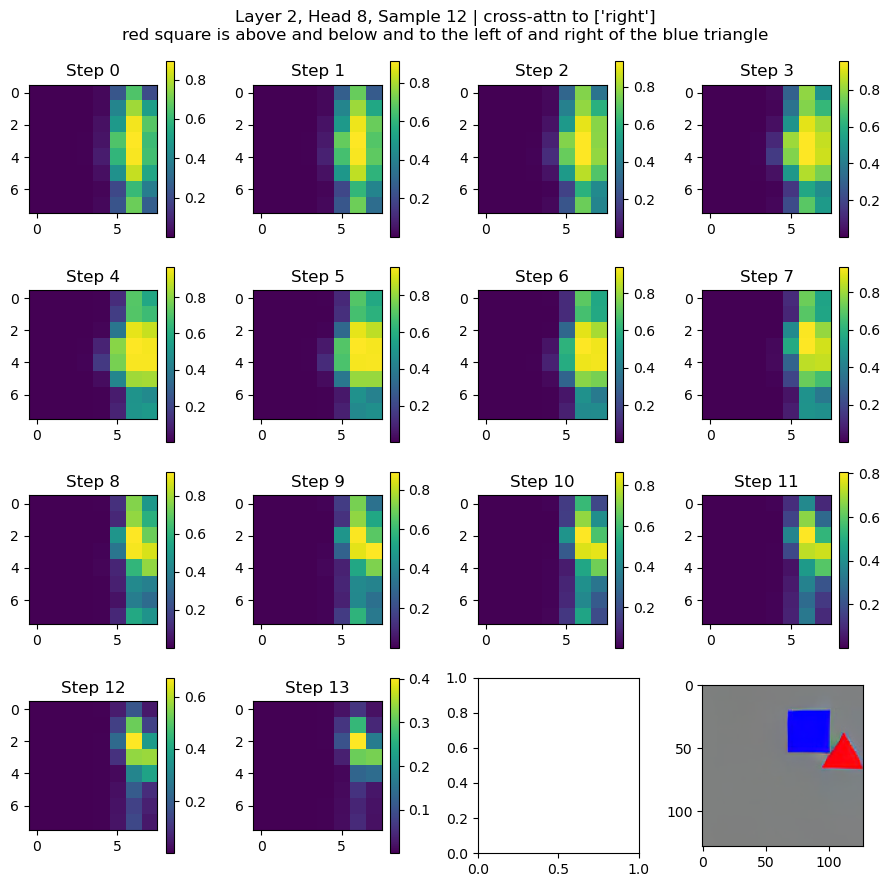

In [67]:
i_layer = 2
j_head = 8
# k_step = 0
n_images = 16
target_words = ["right", ]
token_splits = pipeline.tokenizer.tokenize(prompt)
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
i_sample = 12
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
plt.show()

### Attention QK checking of L2H8

In [31]:
from diffusion.model.nets.PixArt import get_2d_sincos_pos_embed

In [32]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", ]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]

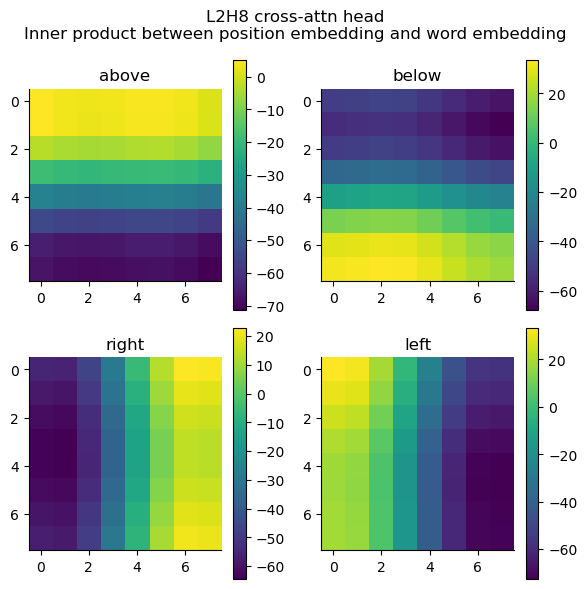

In [33]:
figh, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8 @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP")
plt.show()

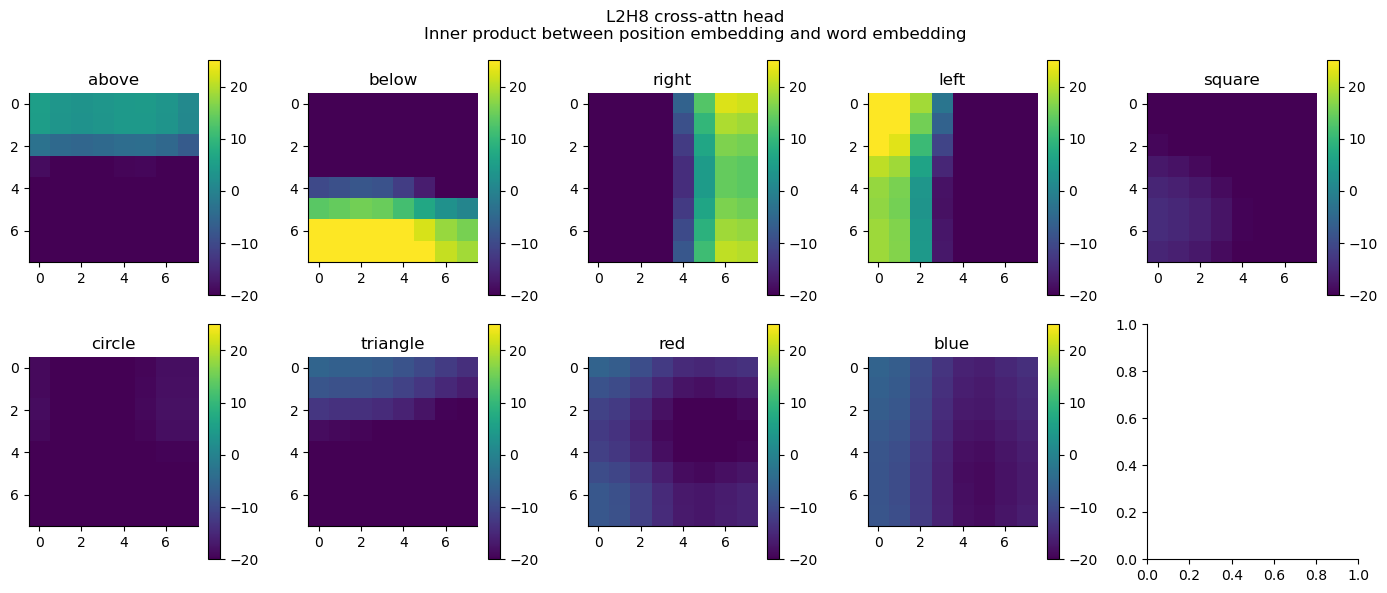

In [34]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", "square", "circle", "triangle", "red", "blue", ]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(2, 5, figsize=(14, 6))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=25, vmin=-20)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
saveallforms(figdir, "L2H8_cross_attn_head_inprod_between_img_pos_embd_and_word_embed_MLP_all_words")
plt.show()

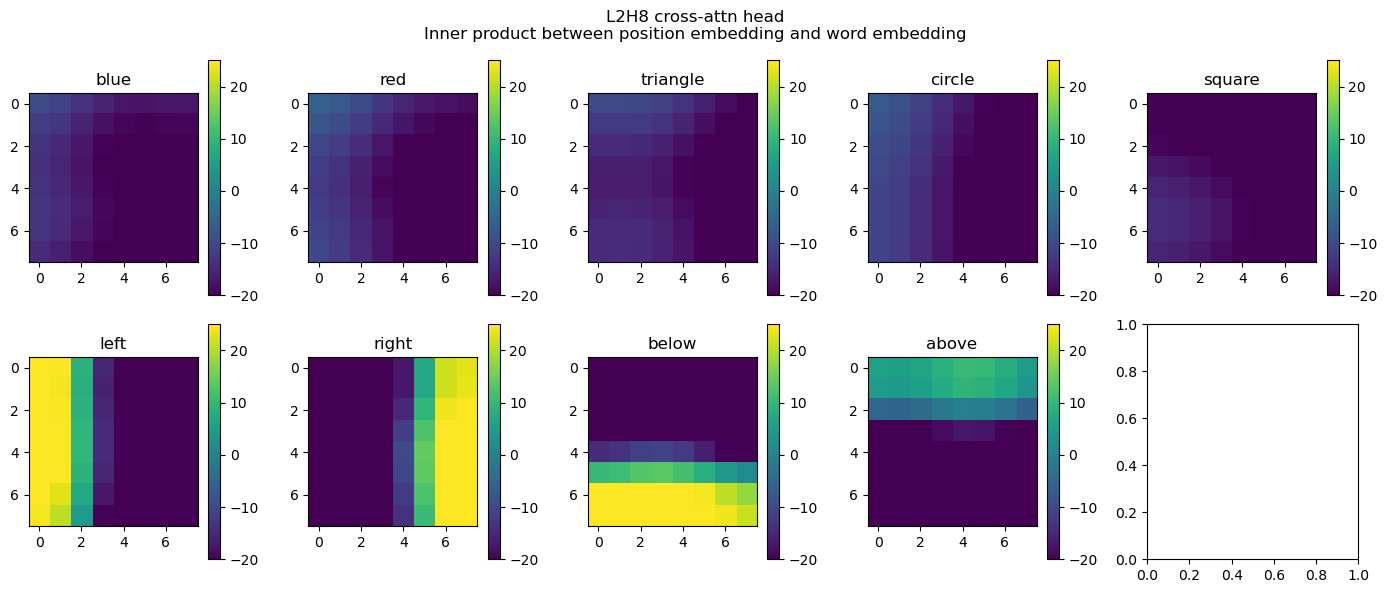

In [ ]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
layer_idx = 2
head_idx = 8
device = "cpu"
relation_words = ["above", "below", "right", "left", "square", "circle", "triangle", "red", "blue", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(2, 5, figsize=(14, 6))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=25, vmin=-20)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
plt.show()

L2H8


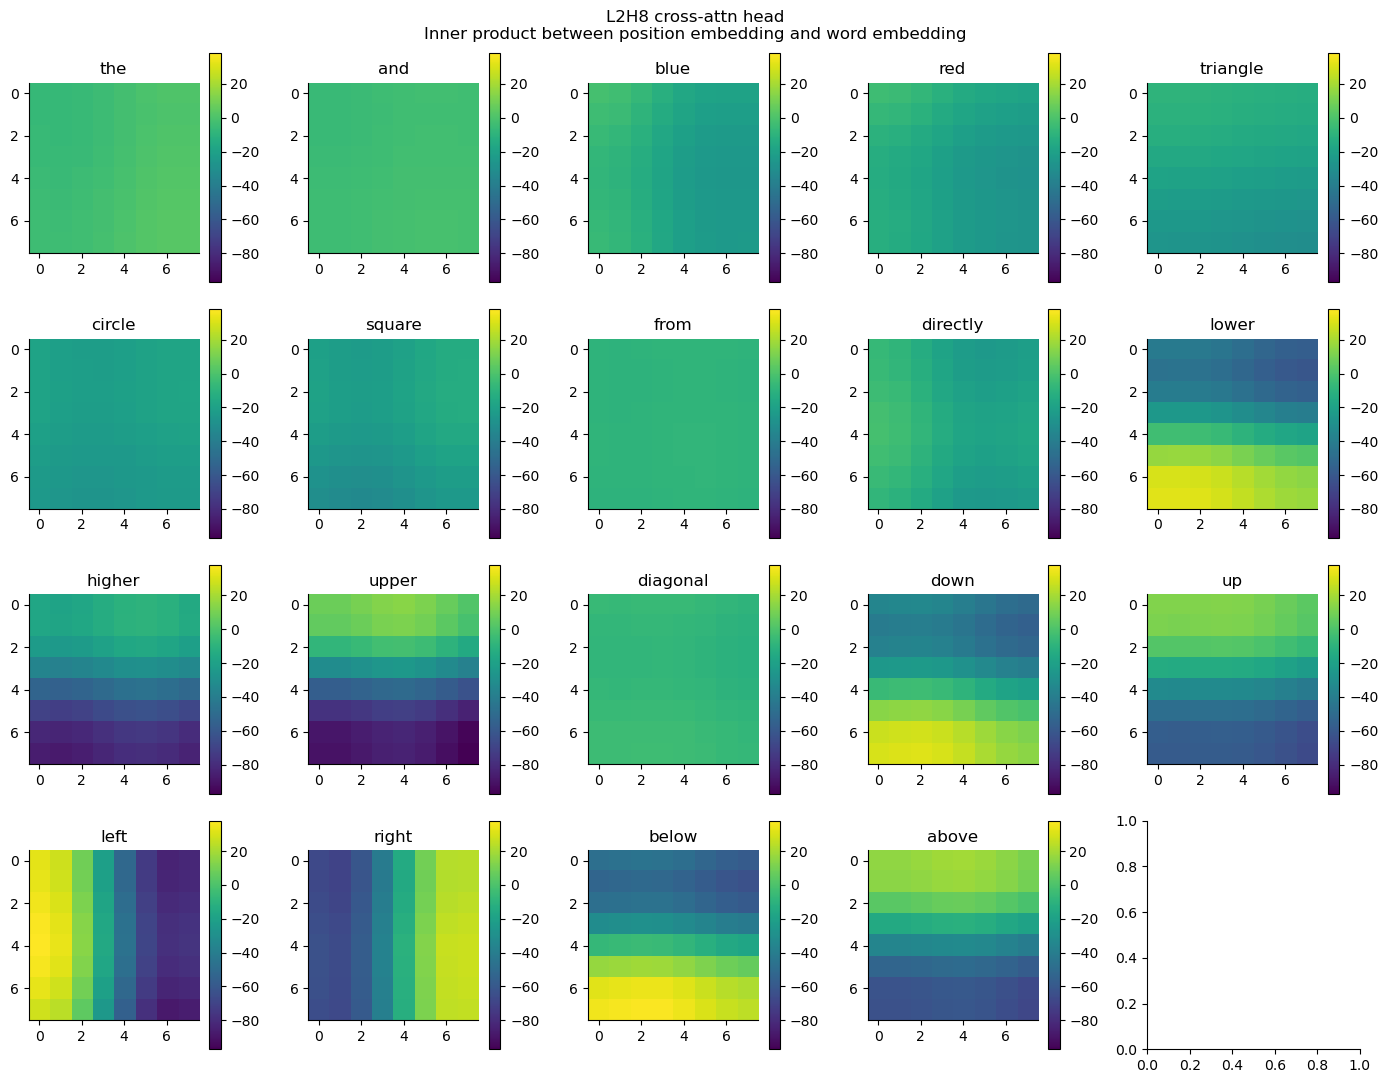

In [153]:
layer_idx = 2
head_idx = 8
print(f"L{layer_idx}H{head_idx}")
device = "cpu"
relation_words = ["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                "square", "circle", "triangle", "red", "blue", "and", "the", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
figh, axs = plt.subplots(4, 5, figsize=(14, 11))
axs = axs.flatten()
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
vmax = inner_prods.max().item()
vmin = inner_prods.min().item()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
# saveallforms(figdir, f"L{layer_idx}H{head_idx}_cross_attn_head_word_inner_prod.png")
plt.show()

### L4H3

In [35]:
prompt

'red square is below and to the right of the blue circle'

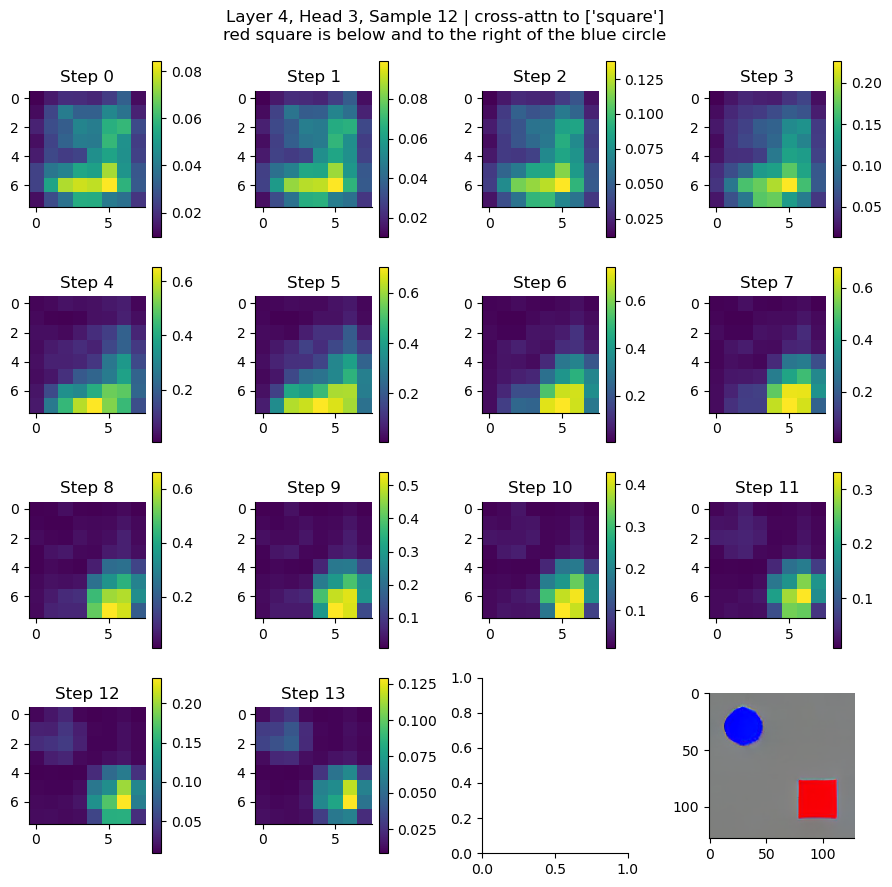

In [36]:
i_layer = 4
j_head = 3
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["square",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

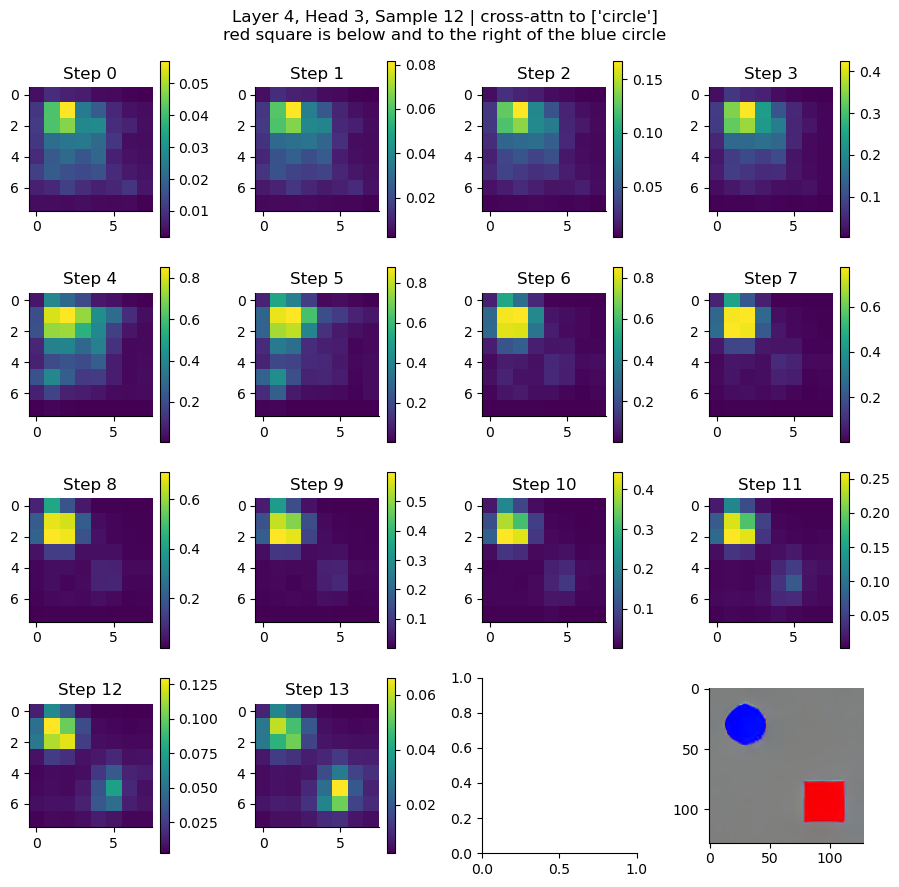

In [37]:
i_layer = 4
j_head = 3
# k_step = 0
i_sample = 12
n_images = 16
target_words = ["circle",]
token_mask = create_multi_hot_token_mask(token_splits, target_words, seq_len=20)
L2H8_cross_attn_maps = (cross_attn_map_stacked[i_layer, :, n_images:, j_head, :, :] * token_mask).sum(dim=-1)
L2H8_cross_attn_maps.shape
fig, axs = plt.subplots(4, 4, figsize=(9, 9))
axs = axs.flatten()
for k_step in range(14):
    plt.sca(axs[k_step])
    plt.imshow(L2H8_cross_attn_maps[k_step, i_sample, :].view(8, 8),)
    plt.colorbar()
    plt.title(f"Step {k_step}")
plt.sca(axs[-1])
plt.imshow(output[0].images[i_sample])
plt.suptitle(f"Layer {i_layer}, Head {j_head}, Sample {i_sample} | cross-attn to {target_words}\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L{i_layer}H{j_head}S{i_sample}_cross_attn_maps_to_{'_'.join(target_words)}_prompt_{prompt.replace(' ', '_')}")
plt.show()

### L2H8+L4H3

In [38]:
import math

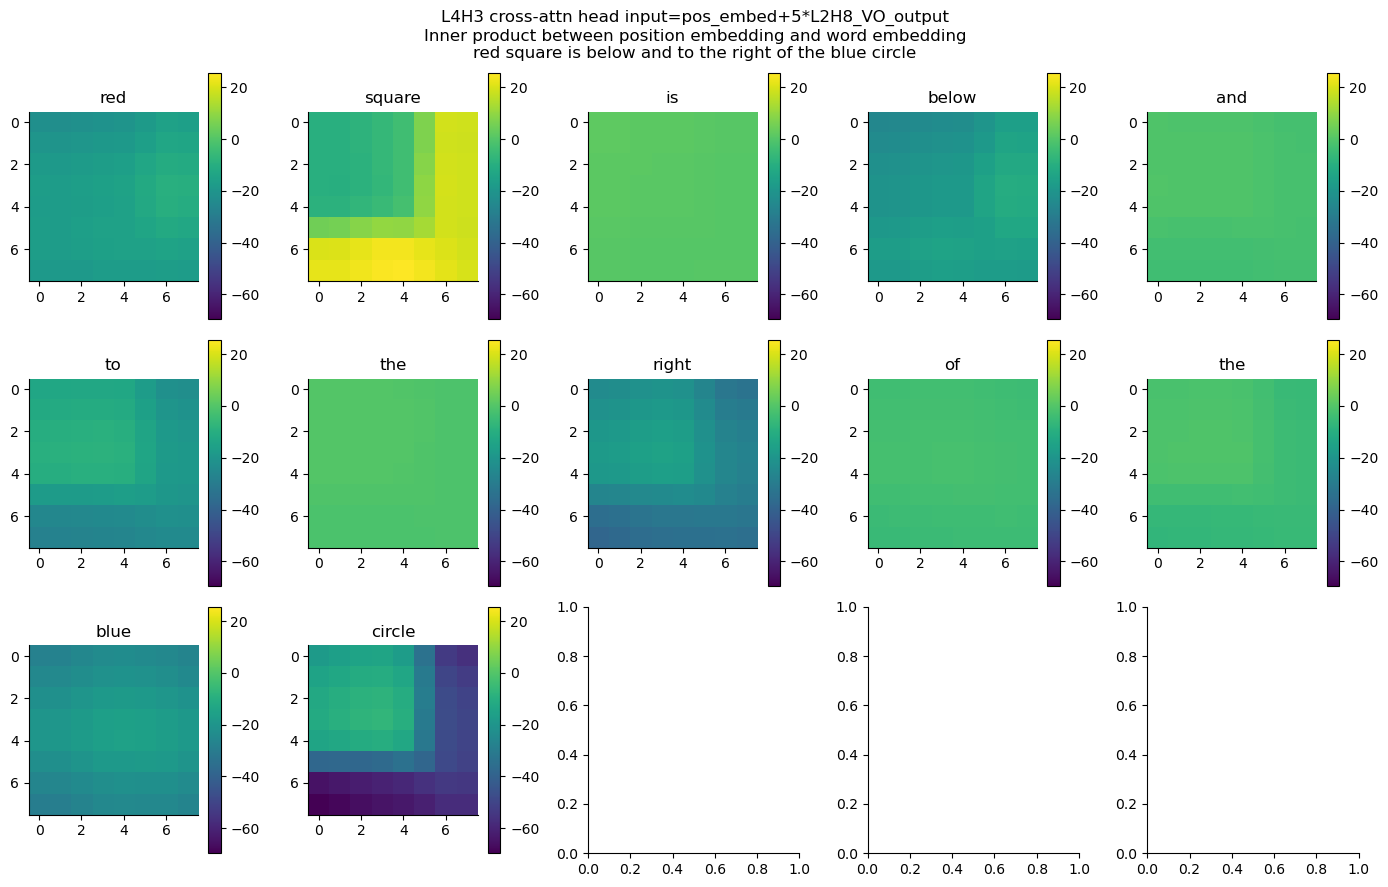

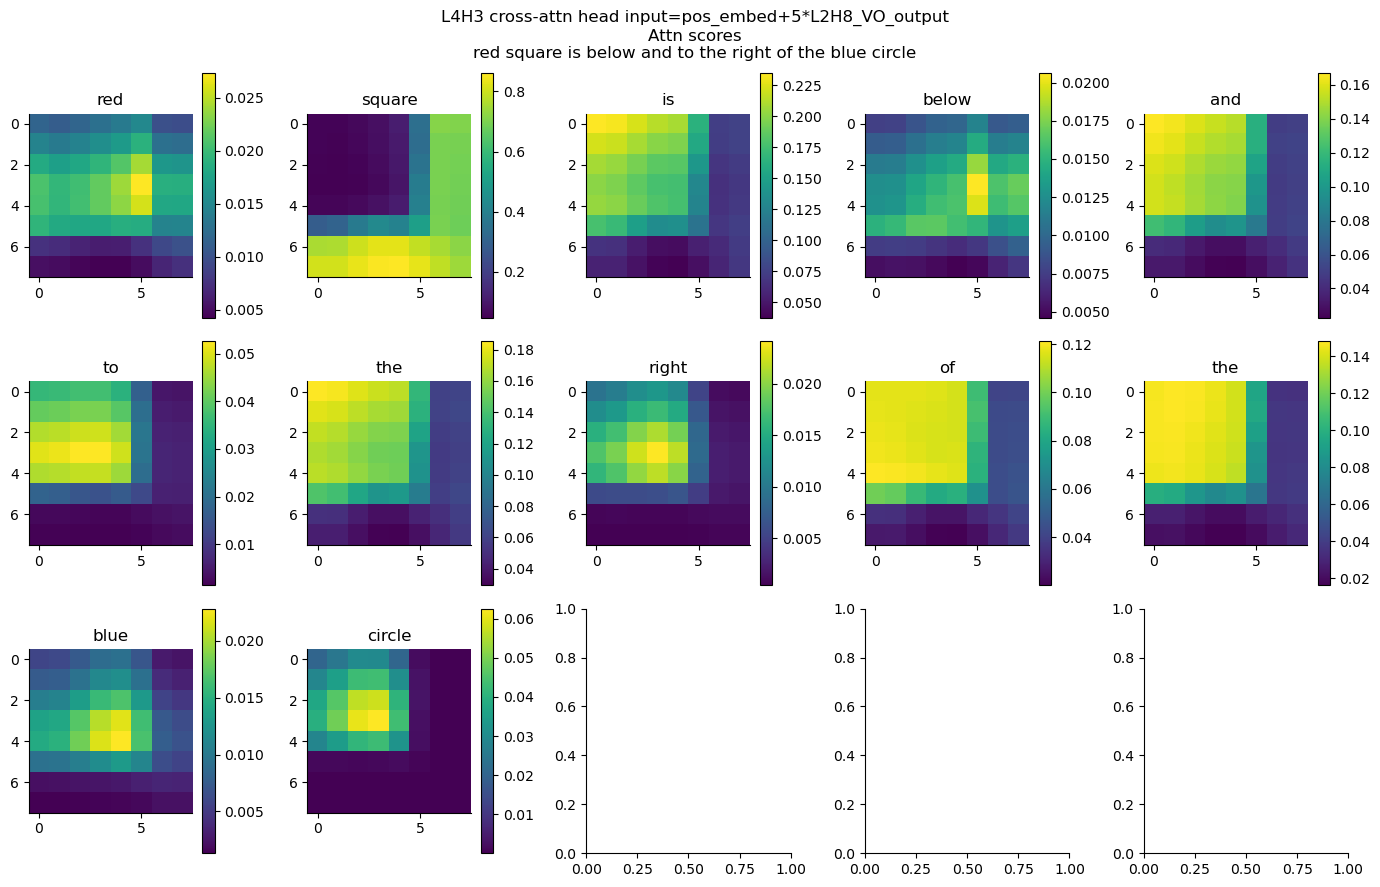

In [39]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
layer_idx = 2
device = "cpu"
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
with torch.no_grad():
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_v(word_embeds_proj)
    word_embed_2v_h8 = word_embed_2v[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v_h8_zero_pad = torch.zeros_like(word_embed_2v)
    word_embed_2v_h8_zero_pad[:, head_idx*head_dim:(head_idx+1)*head_dim] = word_embed_2v_h8
    word_embed_2v_h8_zero_pad_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](word_embed_2v_h8_zero_pad)
    # L2H8 cross-attn head
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T) / math.sqrt(head_dim)
    attn_scores = th.softmax(inner_prods.float(), dim=-1)
    attn_weighted_word_embed_2v_h8_zero_pad = attn_scores.half() @ word_embed_2v_h8_zero_pad
    final_L2H8_head_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](attn_weighted_word_embed_2v_h8_zero_pad)
word_embed_2v_h8_zero_pad_out.shape
final_L2H8_head_out


hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 3
layer_idx = 4
device = "cpu"
alpha = 5
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
# implant the output of L2H8 VO output to the position encoding
pos_embed_plus_info = final_L2H8_head_out.unsqueeze(0) * alpha + pos_embed.half().cuda()
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed_plus_info)
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
vmax = inner_prods.max()
vmin = inner_prods.min()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nInner product between position embedding and word embedding\n{prompt}")
saveallforms(figdir, f"L4H3_cross_attn_head_inprod_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.tight_layout()
plt.show()

attn_scores_L4H3 = (inner_prods / math.sqrt(head_dim)).softmax(dim=-1)
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    attn_scores_per_word = attn_scores_L4H3[:, i_word:i_word+1]
    plt.imshow(attn_scores_per_word.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nAttn scores\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L4H3_cross_attn_head_attn_scores_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.show()

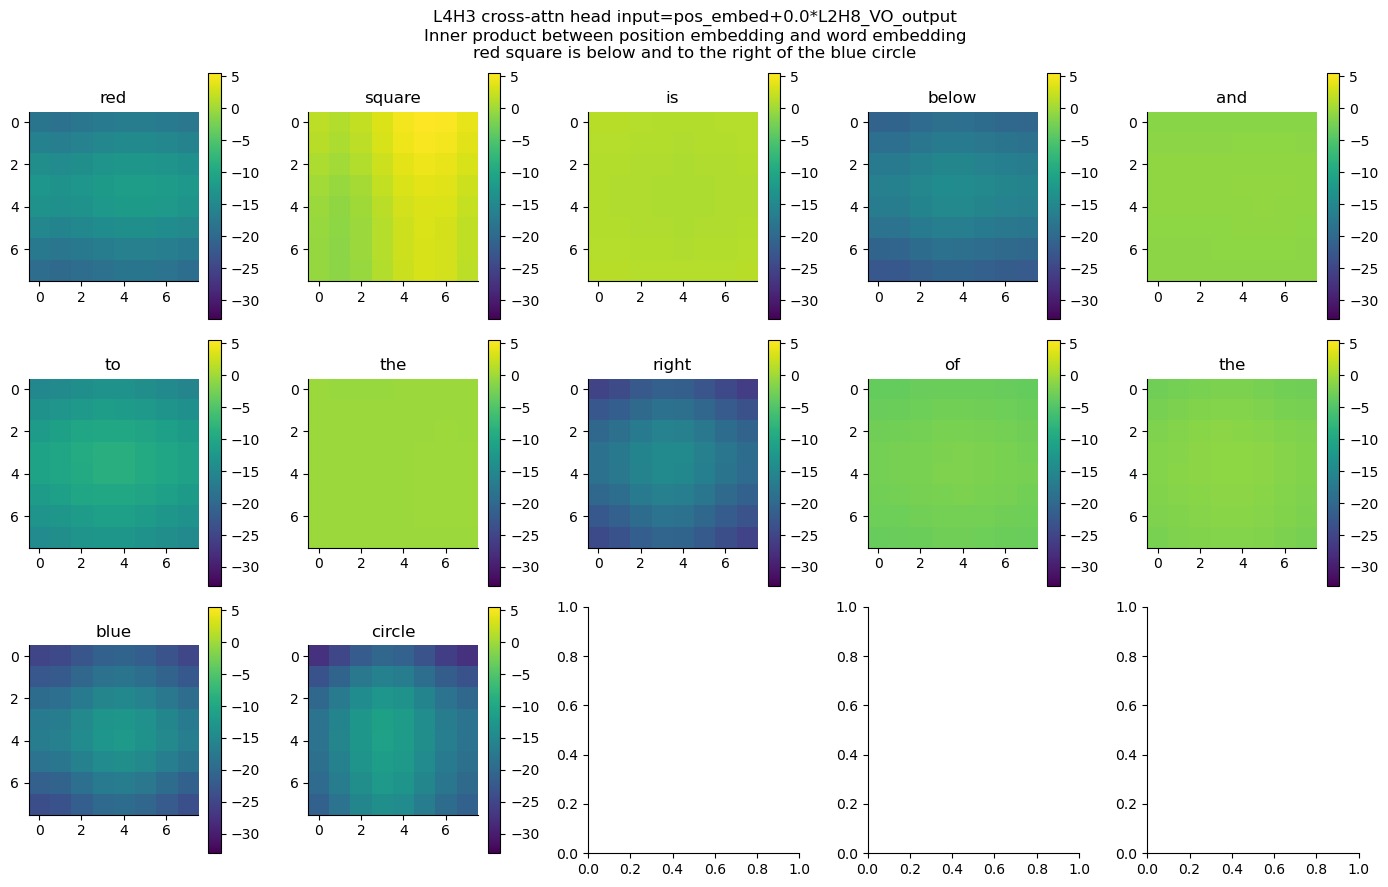

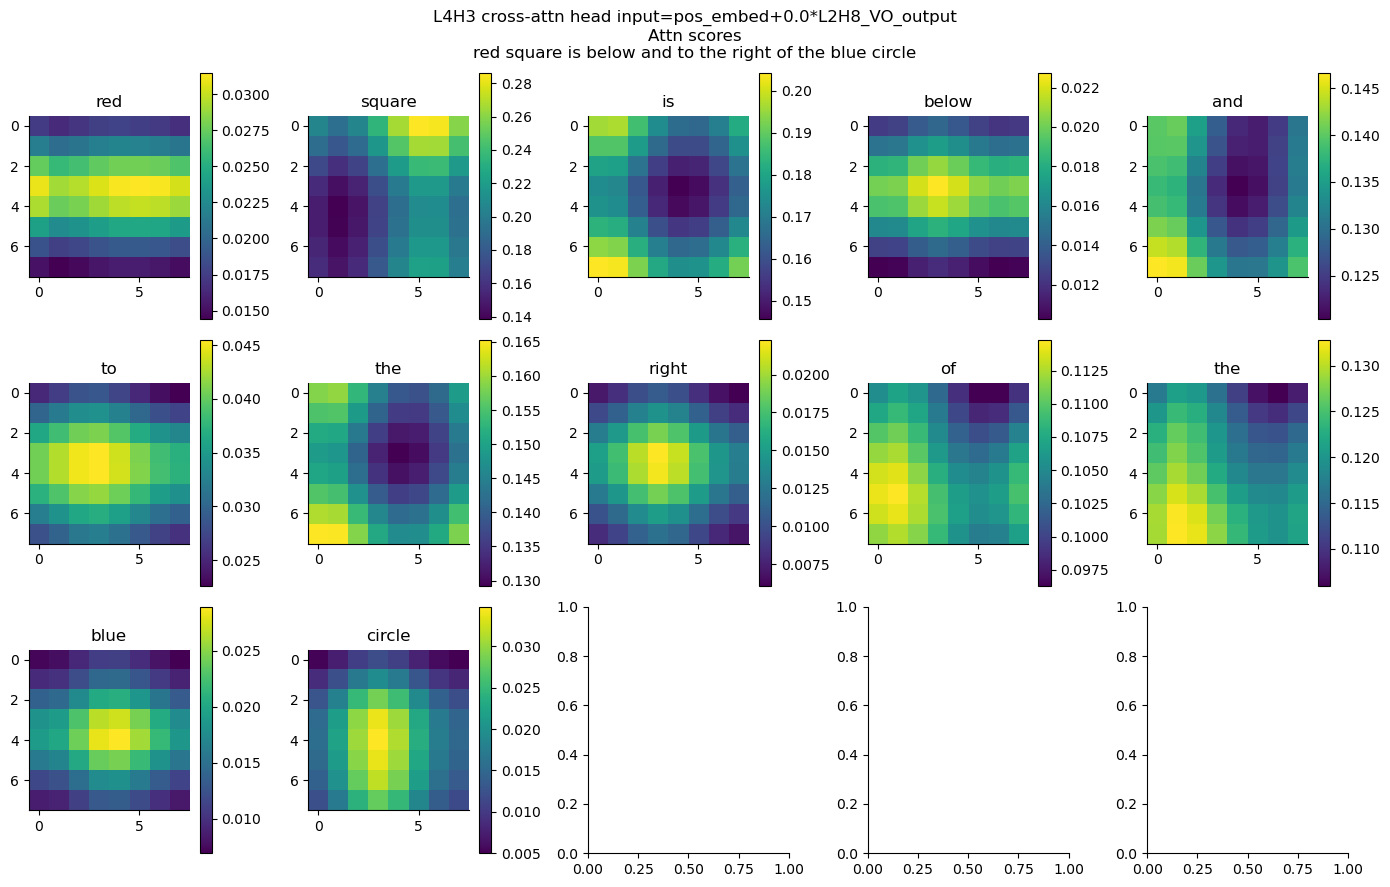

In [40]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 8
layer_idx = 2
device = "cpu"
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
with torch.no_grad():
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_v(word_embeds_proj)
    word_embed_2v_h8 = word_embed_2v[:, head_idx*head_dim:(head_idx+1)*head_dim]
    word_embed_2v_h8_zero_pad = torch.zeros_like(word_embed_2v)
    word_embed_2v_h8_zero_pad[:, head_idx*head_dim:(head_idx+1)*head_dim] = word_embed_2v_h8
    word_embed_2v_h8_zero_pad_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](word_embed_2v_h8_zero_pad)
    # L2H8 cross-attn head
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
    inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T) / math.sqrt(head_dim)
    attn_scores = th.softmax(inner_prods.float(), dim=-1)
    attn_weighted_word_embed_2v_h8_zero_pad = attn_scores.half() @ word_embed_2v_h8_zero_pad
    final_L2H8_head_out = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_out[0](attn_weighted_word_embed_2v_h8_zero_pad)
word_embed_2v_h8_zero_pad_out.shape
final_L2H8_head_out


hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
head_idx = 3
layer_idx = 4
device = "cpu"
alpha = 0.0
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
prompt_tokenized = prompt.split(" ")
token_ids = pipeline.tokenizer.encode(" ".join(prompt_tokenized), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
# implant the output of L2H8 VO output to the position encoding
pos_embed_plus_info = final_L2H8_head_out.unsqueeze(0) * alpha + pos_embed.half().cuda()
pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed_plus_info)
pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
vmax = inner_prods.max()
vmin = inner_prods.min()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    inner_prod = inner_prods[:, i_word:i_word+1]
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nInner product between position embedding and word embedding\n{prompt}")
saveallforms(figdir, f"L4H3_cross_attn_head_inprod_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.tight_layout()
plt.show()

attn_scores_L4H3 = (inner_prods / math.sqrt(head_dim)).softmax(dim=-1)
figh, axs = plt.subplots(3, 5, figsize=(14, 9))
axs = axs.flatten()
for i_word in range(len(prompt_tokenized)):
    plt.sca(axs[i_word])
    attn_scores_per_word = attn_scores_L4H3[:, i_word:i_word+1]
    plt.imshow(attn_scores_per_word.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(prompt_tokenized[i_word])
plt.suptitle(f"L4H3 cross-attn head input=pos_embed+{alpha}*L2H8_VO_output\nAttn scores\n{prompt}")
plt.tight_layout()
saveallforms(figdir, f"L4H3_cross_attn_head_attn_scores_img_pos_embd_plus_alpha{alpha}_L2H8_VO_output_and_word_embed_MLP_prompt_{prompt.replace(' ', '_')}")
plt.show()

### Screening of Heads

In [ ]:
from circuit_toolkit.plot_utils import saveallforms

In [ ]:
pipeline.tokenizer.decode(pipeline.text_encoder.input_ids2dict_ids.keys())

'<pad></s>the and to of is from uply than right down left below above red higher lower directly blue square upper circle triangle diagonal'

In [ ]:
len(["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                          "square", "circle", "triangle", "red", "blue", "and", "the", "of", "to"])

21

In [ ]:
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/cross_attn_posenc_word_emb_filtering"
os.makedirs(figdir, exist_ok=True)

In [ ]:
hidden_size = 768
base_size = 16 // 2
head_dim = hidden_size // 12
layer_idx = 3
head_idx = 1
for layer_idx in range(12):
    for head_idx in range(12):
        print(f"L{layer_idx}H{head_idx}")
        device = "cpu"
        relation_words = ["above", "below", "right", "left", "up", "down", "diagonal", "upper", "higher", "lower", "directly", "from",
                        "square", "circle", "triangle", "red", "blue", "and", "the", ][::-1]
        token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
        word_embeds, attn_mask = pipeline.text_encoder(token_ids)
        word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
        word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
        word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]
        pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
        pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
        pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
        pos_embed_2q_h8 = pos_embed_2q[0, :, head_idx*head_dim:(head_idx+1)*head_dim]
        figh, axs = plt.subplots(4, 5, figsize=(14, 11))
        axs = axs.flatten()
        inner_prods = (pos_embed_2q_h8 @ word_embed_2k_h8.T).detach().cpu()
        vmax = inner_prods.max().item()
        vmin = inner_prods.min().item()
        for i_word in range(len(relation_words)):
            plt.sca(axs[i_word])
            inner_prod = inner_prods[:, i_word:i_word+1]
            plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy(), vmax=vmax, vmin=vmin)
            plt.colorbar()
            plt.title(relation_words[i_word])
        plt.suptitle(f"L{layer_idx}H{head_idx} cross-attn head\nInner product between position embedding and word embedding")
        plt.tight_layout()
        saveallforms(figdir, f"L{layer_idx}H{head_idx}_cross_attn_head_posenc_word_inner_prod.png")
        plt.close()
        plt.show()

L0H0
L0H1
L0H2
L0H3
L0H4
L0H5
L0H6
L0H7
L0H8
L0H9
L0H10
L0H11
L1H0
L1H1
L1H2
L1H3
L1H4
L1H5
L1H6
L1H7
L1H8
L1H9
L1H10
L1H11
L2H0
L2H1
L2H2
L2H3
L2H4
L2H5
L2H6
L2H7
L2H8
L2H9
L2H10
L2H11
L3H0
L3H1
L3H2
L3H3
L3H4
L3H5
L3H6
L3H7
L3H8
L3H9
L3H10
L3H11
L4H0
L4H1
L4H2
L4H3
L4H4
L4H5
L4H6
L4H7
L4H8
L4H9
L4H10
L4H11
L5H0
L5H1
L5H2
L5H3
L5H4
L5H5
L5H6
L5H7
L5H8
L5H9
L5H10
L5H11
L6H0
L6H1
L6H2
L6H3
L6H4
L6H5
L6H6
L6H7
L6H8
L6H9
L6H10
L6H11
L7H0
L7H1
L7H2
L7H3
L7H4
L7H5
L7H6
L7H7
L7H8
L7H9
L7H10
L7H11
L8H0
L8H1
L8H2
L8H3
L8H4
L8H5
L8H6
L8H7
L8H8
L8H9
L8H10
L8H11
L9H0
L9H1
L9H2
L9H3
L9H4
L9H5
L9H6
L9H7
L9H8
L9H9
L9H10
L9H11
L10H0
L10H1
L10H2
L10H3
L10H4
L10H5
L10H6
L10H7
L10H8
L10H9
L10H10
L10H11
L11H0
L11H1
L11H2
L11H3
L11H4
L11H5
L11H6
L11H7
L11H8
L11H9
L11H10
L11H11


### Structure of relation words embeddings w.r.t. keys

In [ ]:
layer_idx = 2
head_idx = 8
head_dim = 768 // 12
relation_words = ["above", "up", "upper", "higher", "below", "down", "lower", "right", "left", "diagonal", "directly", 
                        "square", "circle", "triangle", "red", "blue", "and", "the", "of", ][::-1]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=25, truncation=False)
with torch.no_grad():
    word_embeds, attn_mask = pipeline.text_encoder(token_ids)
    word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)
    word_embed_2k = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_k(word_embeds_proj)
    word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]

In [174]:
word_embed_2k.shape

torch.Size([20, 768])

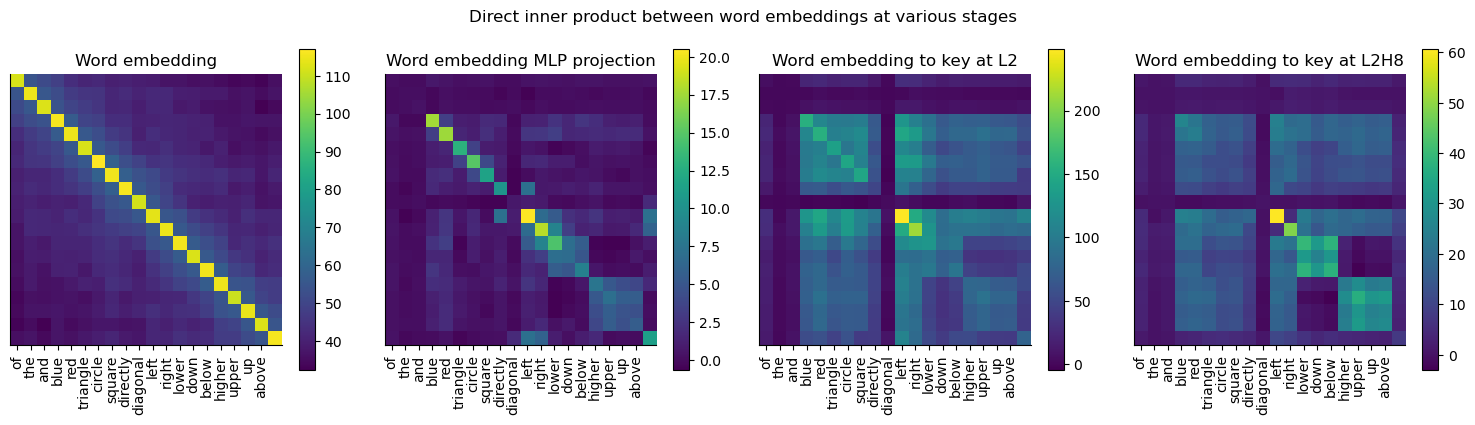

In [179]:
plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow((word_embeds @ word_embeds.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow((word_embeds_proj @ word_embeds_proj.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow((word_embed_2k @ word_embed_2k.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow((word_embed_2k_h8 @ word_embed_2k_h8.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("Direct inner product between word embeddings at various stages")
plt.tight_layout()
plt.show()

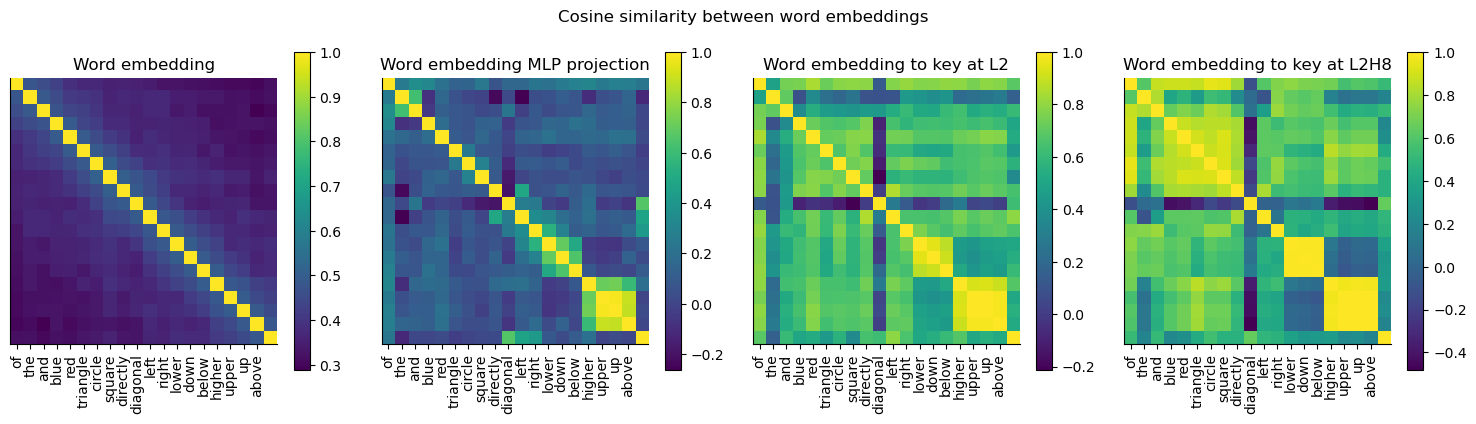

In [180]:
word_embeds = word_embeds.float()
word_embeds_proj = word_embeds_proj.float()
word_embed_2k = word_embed_2k.float()
word_embed_2k_h8 = word_embed_2k_h8.float()

# Compute cosine similarities
word_embeds_norm = word_embeds / word_embeds.norm(dim=-1, keepdim=True)
word_embeds_proj_norm = word_embeds_proj / word_embeds_proj.norm(dim=-1, keepdim=True)
word_embed_2k_norm = word_embed_2k / word_embed_2k.norm(dim=-1, keepdim=True)
word_embed_2k_h8_norm = word_embed_2k_h8 / word_embed_2k_h8.norm(dim=-1, keepdim=True)

plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow((word_embeds_norm @ word_embeds_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow((word_embeds_proj_norm @ word_embeds_proj_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow((word_embed_2k_norm @ word_embed_2k_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow((word_embed_2k_h8_norm @ word_embed_2k_h8_norm.T).detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("Cosine similarity between word embeddings")
plt.tight_layout()
plt.show()

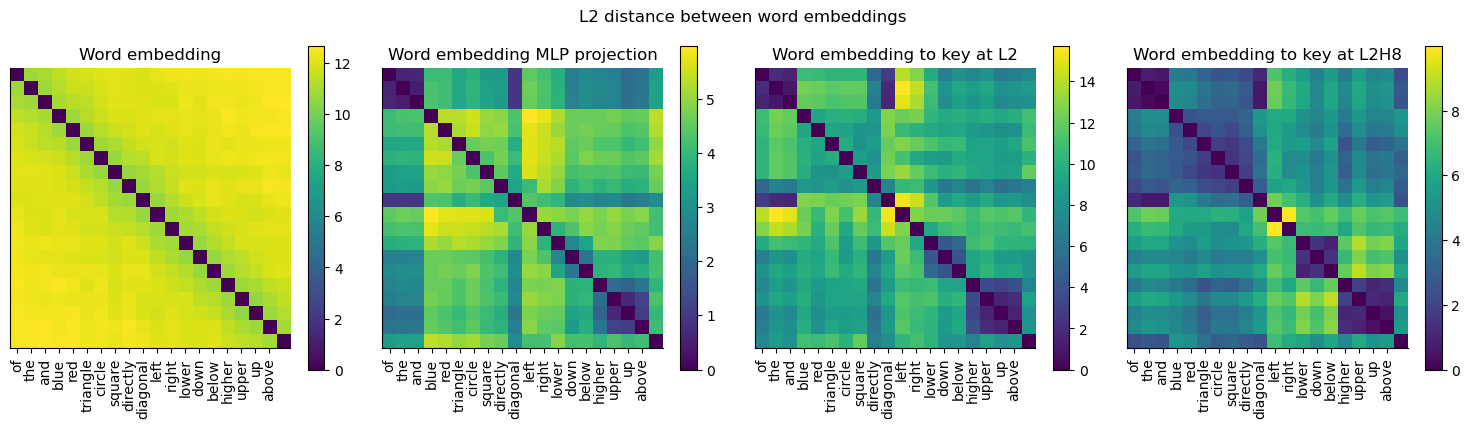

In [181]:

# Compute L2 distances
# word_embeds_expanded = word_embeds.unsqueeze(1)
# word_embeds_proj_expanded = word_embeds_proj.unsqueeze(1)
# word_embed_2k_expanded = word_embed_2k.unsqueeze(1)
# word_embed_2k_h8_expanded = word_embed_2k_h8.unsqueeze(1)
l2_dist_embeds = torch.cdist(word_embeds, word_embeds, p=2)
l2_dist_proj = torch.cdist(word_embeds_proj, word_embeds_proj, p=2)
l2_dist_2k = torch.cdist(word_embed_2k, word_embed_2k, p=2)
l2_dist_2k_h8 = torch.cdist(word_embed_2k_h8, word_embed_2k_h8, p=2)

plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.imshow(l2_dist_embeds.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding")
plt.subplot(1,4,2)
plt.imshow(l2_dist_proj.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding MLP projection")
plt.subplot(1,4,3)
plt.imshow(l2_dist_2k.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2")
plt.subplot(1,4,4)
plt.imshow(l2_dist_2k_h8.detach().cpu())
plt.xticks(range(len(relation_words)), relation_words, rotation=90)
plt.colorbar()
plt.yticks([])
plt.title("Word embedding to key at L2H8")
plt.suptitle("L2 distance between word embeddings")
plt.tight_layout()
plt.show()

### Structure of Position embeding w.r.t. query

In [190]:
head_idx = 8
layer_idx = 2
head_dim = 768 // 12
with torch.no_grad():
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)
    pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
pos_embed_2q_h8

In [202]:
W_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.weight
b_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.bias
W_q_h8 = W_q[head_idx*head_dim:(head_idx+1)*head_dim, :]
b_q_h8 = b_q[head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
U, S, V = th.svd(W_q_h8.float())


In [242]:
V.shape

torch.Size([768, 64])

In [247]:
(pos_embed[0] - (pos_embed[0] @ V @ th.diag(S**2) @ V.T)).norm()

tensor(370.3118)

In [210]:
assert (torch.allclose(pos_embed_2q_h8.float(), pos_embed.cuda().float() @ W_q_h8.T.cuda().float() + b_q_h8.cuda().float(), rtol=1e-3, atol=1e-3))

In [271]:
head_idx = 9
layer_idx = 5
head_dim = 768 // 12
with torch.no_grad():
    pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
    pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).cuda()
    # pos_embed_2q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q(pos_embed.half().cuda())
    # pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]
    W_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.weight
    # b_q = pipeline.transformer.transformer_blocks[layer_idx].attn2.to_q.bias
    W_q_h8 = W_q[head_idx*head_dim:(head_idx+1)*head_dim, :]
    # b_q_h8 = b_q[head_idx*head_dim:(head_idx+1)*head_dim]
    U, S, V = th.svd(W_q_h8.float())
    proj_var = (pos_embed[0] @ V @ th.diag(S**2) @ V.T).norm().item()
    proj_space_var = (pos_embed[0] @ V @ V.T).norm().item()
    residual_VS2V = (pos_embed[0] - (pos_embed[0] @ V @ th.diag(S**2) @ V.T)).norm().item()
    residual_V = (pos_embed[0] - (pos_embed[0] @ V @ V.T)).norm().item()
    pos_embed_var = pos_embed[0].norm().item()
    # print(f"Explained variance: {1 - residual_VS2V / pos_embed_var}, subspace: {1 - residual_V / pos_embed_var}")
    print(f"Proj var: {proj_var}, proj space var: {proj_space_var}")

Proj var: 392.2591552734375, proj space var: 61.26609802246094


In [212]:
W_q_h8.shape

torch.Size([64, 768])

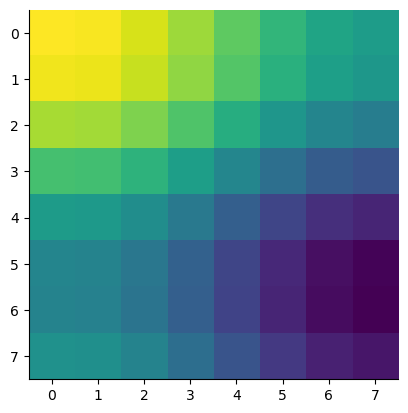

In [220]:
plt.imshow(pos_embed_2q_h8[0,:,-10].view(8, 8).detach().cpu())

In [221]:
W_q_h8.shape

torch.Size([64, 768])

In [224]:
W_q_h8 = W_q_h8.detach().float().cpu()

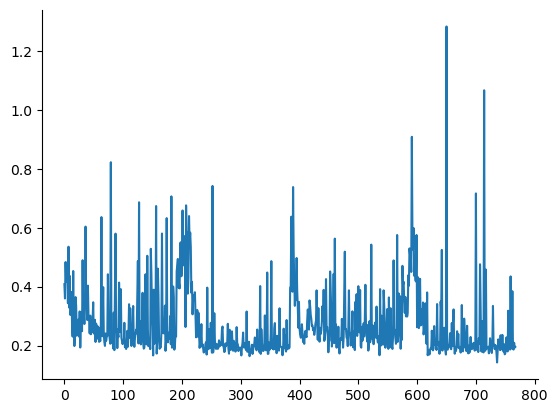

In [225]:
plt.plot(W_q_h8.float().cpu().norm(dim=0))

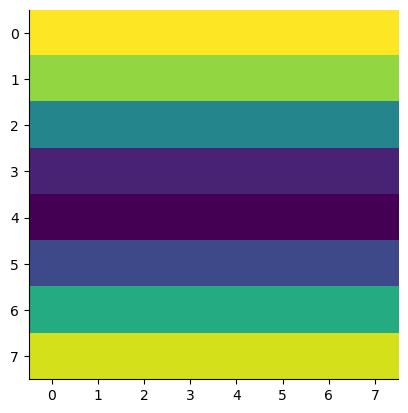

In [236]:
plt.imshow(pos_embed[0, :, 580].view(base_size, base_size).detach().cpu().numpy())

### Scratch

In [ ]:
pipeline.transformer

Transformer2DModel(
  (pos_embed): PatchEmbed(
    (proj): Conv2d(4, 768, kernel_size=(2, 2), stride=(2, 2))
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x BasicTransformerBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn1): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0): Linear(in_features=768, out_features=768, bias=True)
          (1): Dropout(p=0.0, inplace=False)
        )
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn2): Attention(
        (to_q): Linear(in_features=768, out_features=768, bias=True)
        (to_k): Linear(in_features=768, out_features=768, bias=True)
        (to_v): Linear(in_features=768, out_features=768, bias=True)
        (to_out): ModuleList(
          (0):

In [ ]:
pipeline.transformer.transformer_blocks[2].attn2.to_k

Linear(in_features=768, out_features=768, bias=True)

In [ ]:
pipeline.transformer.transformer_blocks[2].attn2.to_q

Linear(in_features=768, out_features=768, bias=True)

In [ ]:
hidden_size = 768
base_size = 16 // 2
device = "cpu"
pos_embed = get_2d_sincos_pos_embed(hidden_size, (base_size, base_size), base_size=base_size)
pos_embed = torch.from_numpy(pos_embed).unsqueeze(0).to(torch.float32).to(device)

In [ ]:
pos_embed_2q = pipeline.transformer.transformer_blocks[2].attn2.to_q(pos_embed.half().cuda())

In [ ]:
pos_embed.shape

torch.Size([1, 64, 768])

In [ ]:
head_dim = hidden_size // 12
head_idx = 8
pos_embed_2q_h8 = pos_embed_2q[:, :, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
from inspect import signature, getsource
print(getsource(pipeline.tokenizer.encode))

    @add_end_docstrings(
        ENCODE_KWARGS_DOCSTRING,
        """
            **kwargs: Passed along to the `.tokenize()` method.
        """,
        """
        Returns:
            `List[int]`, `torch.Tensor`, `tf.Tensor` or `np.ndarray`: The tokenized ids of the text.
        """,
    )
    def encode(
        self,
        text: Union[TextInput, PreTokenizedInput, EncodedInput],
        text_pair: Optional[Union[TextInput, PreTokenizedInput, EncodedInput]] = None,
        add_special_tokens: bool = True,
        padding: Union[bool, str, PaddingStrategy] = False,
        truncation: Union[bool, str, TruncationStrategy] = None,
        max_length: Optional[int] = None,
        stride: int = 0,
        return_tensors: Optional[Union[str, TensorType]] = None,
        **kwargs,
    ) -> List[int]:
        """
        Converts a string to a sequence of ids (integer), using the tokenizer and vocabulary.

        Same as doing `self.convert_tokens_to_ids(self.tokenize(text))`.

     

In [ ]:
relation_words = ["above", "below", "right", "left"]
token_ids = pipeline.tokenizer.encode(" ".join(relation_words), max_length=20, truncation=False)
word_embeds, attn_mask = pipeline.text_encoder(token_ids)
word_embeds.shape

torch.Size([5, 4096])

In [ ]:
pipeline.transformer.caption_projection

PixArtAlphaTextProjection(
  (linear_1): Linear(in_features=4096, out_features=768, bias=True)
  (act_1): GELU(approximate='tanh')
  (linear_2): Linear(in_features=768, out_features=768, bias=True)
)

In [ ]:
word_embeds_proj = pipeline.transformer.caption_projection(word_embeds)

In [ ]:
word_embed_2k = pipeline.transformer.transformer_blocks[2].attn2.to_k(word_embeds_proj)

In [ ]:
word_embed_2k.shape

torch.Size([5, 768])

In [ ]:
word_embed_2k_h8 = word_embed_2k[:, head_idx*head_dim:(head_idx+1)*head_dim]

In [ ]:
word_embed_2k_h8.shape

torch.Size([5, 64])

In [ ]:
pos_embed_2q_h8.shape

torch.Size([1, 64, 64])

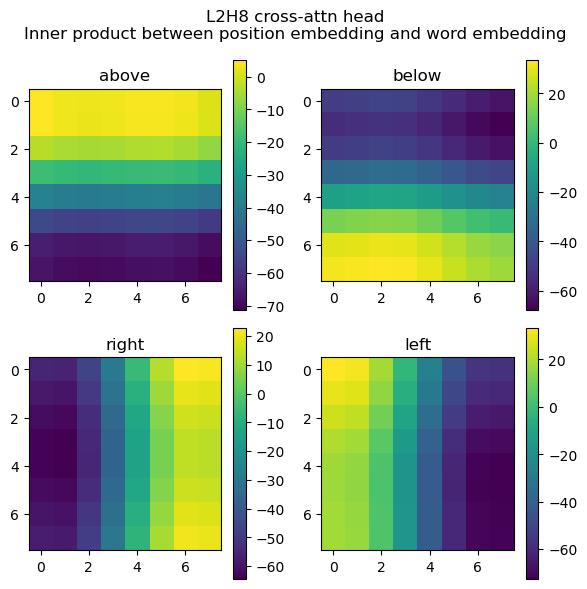

In [ ]:
figh, axs = plt.subplots(2, 2, figsize=(6, 6))
axs = axs.flatten()
for i_word in range(len(relation_words)):
    plt.sca(axs[i_word])
    inner_prod = pos_embed_2q_h8[0] @ word_embed_2k_h8[i_word:i_word+1].T
    plt.imshow(inner_prod.view(8, 8).detach().cpu().numpy())
    plt.colorbar()
    plt.title(relation_words[i_word])
plt.suptitle(f"L2H8 cross-attn head\nInner product between position embedding and word embedding")
plt.tight_layout()
plt.show()